## Datasets

You are provided with the  dataset on eLearning. 
There were several changes made to the dataset: columns dropped/added. 

The dataset is from the U.S. Small Business Administration (SBA) The U.S. SBA was founded in 1953 on the principle of promoting and assisting small enterprises in the U.S. credit market (SBA Overview and History, US Small Business Administration (2015)). Small businesses have been a primary source of job creation in the United States; therefore, fostering small business formation and growth has social benefits by creating job opportunities and reducing unemployment. There have been many success stories of start-ups receiving SBA loan guarantees such as FedEx and Apple Computer. However, there have also been stories of small businesses and/or start-ups that have defaulted on their SBA-guaranteed loans.  
More info on the original dataset: https://www.kaggle.com/mirbektoktogaraev/should-this-loan-be-approved-or-denied



**Don't use original datasets, use only dataset provided with project requirements in eLearning**

## Models

You will need to train and tune two types of models:
- GBM (H2O)
- LightGBM. To install LightGBM, run following command from your terminal after activating class virtual environment:  `pip install lightgbm==3.3.5` 


You will train and tune 2 models for each task for the total of 2 final models. 


***First, split he dataset to Train/Validation/Test, before applying any encodings clean-up or feature engineering. 
It is important to understand all the steps before model training, so that you can reliably replicate and test them to produce scoring function.***


## Saved all artifacts

Saved all artifacts needed for scoring function:
- Trained model
- Encoders


# Preparation

In [1]:
# Import libraries

import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 1500)
import warnings
warnings.filterwarnings('ignore')
#Extend cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))


## ****************** Load Data example ****************** 

In [2]:
import pandas as pd

df = pd.read_csv("./data/SBA_loans_project_2.zip")

In [3]:
data = df

In [4]:
print(df.shape)
df.head()

(807450, 21)


,index,City,State,Zip,Bank,BankState,NAICS,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,DisbursementGross,BalanceGross,GrAppv,SBA_Appv,LoanInd,MIS_Status
0,0,PRINCETON,MN,55371,PEOPLES BANK OF COMMERCE,MN,441120,4,2.0,0,0,1,0,N,N,"$114,577.00",$0.00,"$114,577.00","$85,933.00",1,0
1,1,Kansas city,MO,64116,BANK OF HAYS,KS,481111,14,1.0,0,14,0,1,N,N,"$25,000.00",$0.00,"$25,000.00","$12,500.00",7,0
2,2,BELLWOOD,PA,16617,FIRST COMMONWEALTH BANK,PA,334417,10,1.0,0,2,1,1,0,N,"$85,000.00",$0.00,"$85,000.00","$42,500.00",4,0
3,3,GRAND PRAIRIE,TX,75050,PROSPERITY BANK,TX,0,18,1.0,0,0,1,0,N,N,"$230,000.00",$0.00,"$230,000.00","$195,500.00",5,0
4,4,EL PASO,TX,79925,WESTSTAR BANK,TX,423220,4,1.0,0,4,0,1,N,N,"$32,000.00",$0.00,"$32,000.00","$16,000.00",9,0


In [5]:
"""
Created on Mon Mar 18 18:25:50 2019

@author: Uri Smashnov

Purpose: Analyze input Pandas DataFrame and return stats per column
Details: The function calculates levels for categorical variables and allows to analyze summarized information

To view wide table set following Pandas options:
pd.set_option('display.width', 1000)
pd.set_option('max_colwidth',200)
"""
import pandas as pd
def describe_more(df,normalize_ind=False, weight_column=None, skip_columns=[], dropna=True):
    var = [] ; l = [] ; t = []; unq =[]; min_l = []; max_l = [];
    assert isinstance(skip_columns, list), "Argument skip_columns should be list"
    if weight_column is not None:
        if weight_column not in list(df.columns):
            raise AssertionError('weight_column is not a valid column name in the input DataFrame')
      
    for x in df:
        if x in skip_columns:
            pass
        else:
            var.append( x )
            uniq_counts = len(pd.value_counts(df[x],dropna=dropna))
            uniq_counts = len(pd.value_counts(df[x], dropna=dropna)[pd.value_counts(df[x],dropna=dropna)>0])
            l.append(uniq_counts)
            t.append( df[ x ].dtypes )
            min_l.append(df[x].apply(str).str.len().min())
            max_l.append(df[x].apply(str).str.len().max())
            if weight_column is not None and x not in skip_columns:
                df2 = df.groupby(x).agg({weight_column: 'sum'}).sort_values(weight_column, ascending=False)
                df2['authtrans_vts_cnt']=((df2[weight_column])/df2[weight_column].sum()).round(2)
                unq.append(df2.head(n=100).to_dict()[weight_column])
            else:
                df_cat_d = df[x].value_counts(normalize=normalize_ind,dropna=dropna).round(decimals=2)
                df_cat_d = df_cat_d[df_cat_d>0]
                #unq.append(df[x].value_counts().iloc[0:100].to_dict())
                unq.append(df_cat_d.iloc[0:200].to_dict())
                
            
    levels = pd.DataFrame( { 'A_Variable' : var , 'Levels' : l , 'Datatype' : t ,
                             'Min Length' : min_l,
                             'Max Length': max_l,
                             'Level_Values' : unq} )
    #levels.sort_values( by = 'Levels' , inplace = True )
    return levels

In [6]:
desc_df = describe_more(df)
pd.set_option('display.width', 200)
desc_df.head(n=200)

,A_Variable,Levels,Datatype,Min Length,Max Length,Level_Values
0,index,807450,int64,1,6,"{0: 1, 538292: 1, 538294: 1, 538295: 1, 538296..."
1,City,31282,object,1,30,"{'LOS ANGELES': 10411, 'HOUSTON': 9199, 'NEW Y..."
2,State,51,object,2,3,"{'CA': 117588, 'TX': 63276, 'NY': 51662, 'FL':..."
3,Zip,32684,int64,1,5,"{90015: 859, 10001: 828, 93401: 686, 90010: 65..."
4,Bank,5723,object,3,30,"{'BANK OF AMERICA NATL ASSOC': 78084, 'WELLS F..."
5,BankState,56,object,2,3,"{'CA': 106262, 'NC': 71538, 'IL': 59243, 'OH':..."
6,NAICS,1308,int64,1,6,"{0: 181513, 722110: 25135, 722211: 17482, 8111..."
7,NoEmp,572,int64,1,4,"{1: 137896, 2: 124295, 3: 81375, 4: 66150, 5: ..."
8,NewExist,3,float64,3,3,"{1.0: 579047, 2.0: 227352, 0.0: 929}"
9,CreateJob,240,int64,1,4,"{0: 564999, 1: 56654, 2: 51866, 3: 25911, 4: 1..."


In [7]:
df.columns

Index(['index', 'City', 'State', 'Zip', 'Bank', 'BankState', 'NAICS', 'NoEmp', 'NewExist', 'CreateJob', 'RetainedJob', 'FranchiseCode', 'UrbanRural', 'RevLineCr', 'LowDoc', 'DisbursementGross',
       'BalanceGross', 'GrAppv', 'SBA_Appv', 'LoanInd', 'MIS_Status'],
      dtype='object')

In [8]:
df.shape

(807450, 21)

In [9]:
(df['MIS_Status'].value_counts()) / len(df) * 100

0    82.438293
1    17.561707
Name: MIS_Status, dtype: float64

**The class seems extremely imbalanced for the dependent variabel**


# ** Data Cleaning **

In [10]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

# # reset all display options to default
# pd.reset_option('display.max_columns')
# pd.reset_option('display.max_rows')
# pd.reset_option('display.width')
# pd.reset_option('display.max_colwidth')

**Encode numerical variables that come as strings $100.01 converted to numerical value**

In [11]:
# Data Cleaning process

cols_to_convert = ['DisbursementGross', 'BalanceGross', 'GrAppv', 'SBA_Appv']
df[cols_to_convert] = df[cols_to_convert].replace('[\$,]', '', regex=True).astype(float)


**Encode replace missing values**

In [12]:
#Replace missing values

values_to_fill = {}
for col in df.drop(columns=['MIS_Status']).columns:
    if df[col].dtype == 'object':
        values_to_fill[col] = "Missing"
    else:
        values_to_fill[col] = 0

df.fillna(value=values_to_fill,inplace=True)
df.head(2)

,index,City,State,Zip,Bank,BankState,NAICS,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,DisbursementGross,BalanceGross,GrAppv,SBA_Appv,LoanInd,MIS_Status
0,0,PRINCETON,MN,55371,PEOPLES BANK OF COMMERCE,MN,441120,4,2.0,0,0,1,0,N,N,114577.0,0.0,114577.0,85933.0,1,0
1,1,Kansas city,MO,64116,BANK OF HAYS,KS,481111,14,1.0,0,14,0,1,N,N,25000.0,0.0,25000.0,12500.0,7,0


In [13]:
# Testing for a column; Looks nice
print(df['LowDoc'].unique())
df['LowDoc'].value_counts()
# np.sum(df['RevLineCr'].value_counts())

['N' 'Y' 'S' 'Missing' 'C' '0' 'R' 'A' '1']


N          702838
Y          99254 
Missing    2291  
0          1333  
C          681   
S          542   
A          444   
R          66    
1          1     
Name: LowDoc, dtype: int64

# ** Split dataset to Train/Validation/Test ** 

In [14]:
# Splitting the dataset in train and test
from sklearn.model_selection import train_test_split

# Splitting data into target and indenpendent variable
target = 'MIS_Status'
X = df.drop(columns = target)
y = df[target]


# split the data into training and test sets (80/20 split)
X_train_org, X_test_org, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# split the training data further into training and validation sets (60/20/20 split)
X_train_org, X_val_org, y_train, y_val = train_test_split(X_train_org, y_train, test_size=0.25, random_state=42)


### Creating Train and Test Dataset for further processing

Keeping X_train_org, X_val_org, and X_test_org variables as original split dataset

In [15]:
# holding out test set and performing anaylysis on X_train dataset!
X_train = X_train_org.copy()
X_val = X_val_org.copy()
X_test = X_test_org.copy()

# Dropping index column
X_train = X_train.drop(columns = 'index')
X_val = X_val.drop(columns = 'index')
X_test = X_test.drop(columns = 'index')
X_train.head(2)

,City,State,Zip,Bank,BankState,NAICS,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,DisbursementGross,BalanceGross,GrAppv,SBA_Appv,LoanInd
660705,SUSSEX,WI,53089,U.S. BANK NATIONAL ASSOCIATION,WI,333512,1,2.0,0,0,1,0,N,Y,100000.0,0.0,100000.0,80000.0,3
489443,BELLE VERNON,PA,15012,"PNC BANK, NATIONAL ASSOCIATION",DE,541211,1,1.0,1,1,1,1,Y,N,95048.0,0.0,35000.0,17500.0,4


In [16]:
# checking the size of datasets

print('X_train size', X_train.shape)
print('X_val size', X_val.shape)
print('X_test size', X_test.shape)

X_train size (484470, 19)
X_val size (161490, 19)
X_test size (161490, 19)


## ** Encoding the variables:**

fit performed on train, Validation dataset and Test data is only trasformed (not fitted on) to avoid data leakage

In [17]:
# Encoding the variables:

from copy import deepcopy
import category_encoders as ce

#Categorical encoders disctionary
cat_encoders = {}
#New categorical (encoded) columns
cat_enc_columns = []

for col in X_train.columns:
          if X_train[col].dtype == 'object':
                # Target encoding
                target_encoder = ce.TargetEncoder(cols=[col], min_samples_leaf=20, smoothing=10)
                target_encoder.fit(X_train[col],y_train)
                new_col_name = col+"_tr"
                X_train[new_col_name] = target_encoder.transform(X_train[col])
                X_val[new_col_name] = target_encoder.transform(X_val[col])
                X_test[new_col_name] = target_encoder.transform(X_test[col])
                cat_encoders[col] = [deepcopy(target_encoder),"tr"]
                cat_enc_columns.append(new_col_name)
cat_encoders



{'City': [TargetEncoder(cols=['City']), 'tr'],
 'State': [TargetEncoder(cols=['State']), 'tr'],
 'Bank': [TargetEncoder(cols=['Bank']), 'tr'],
 'BankState': [TargetEncoder(cols=['BankState']), 'tr'],
 'RevLineCr': [TargetEncoder(cols=['RevLineCr']), 'tr'],
 'LowDoc': [TargetEncoder(cols=['LowDoc']), 'tr']}

### Dataset with encoded variables

In [18]:
X_train.head(2)

,City,State,Zip,Bank,BankState,NAICS,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,DisbursementGross,BalanceGross,GrAppv,SBA_Appv,LoanInd,City_tr,State_tr,Bank_tr,BankState_tr,RevLineCr_tr,LowDoc_tr
660705,SUSSEX,WI,53089,U.S. BANK NATIONAL ASSOCIATION,WI,333512,1,2.0,0,0,1,0,N,Y,100000.0,0.0,100000.0,80000.0,3,0.116539,0.117814,0.173724,0.115492,0.146808,0.089707
489443,BELLE VERNON,PA,15012,"PNC BANK, NATIONAL ASSOCIATION",DE,541211,1,1.0,1,1,1,1,Y,N,95048.0,0.0,35000.0,17500.0,4,0.151119,0.149039,0.194693,0.254314,0.254580,0.187415


In [19]:
X_val.head(2)

,City,State,Zip,Bank,BankState,NAICS,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,DisbursementGross,BalanceGross,GrAppv,SBA_Appv,LoanInd,City_tr,State_tr,Bank_tr,BankState_tr,RevLineCr_tr,LowDoc_tr
521853,FOSSTON,MN,56542,CAPITAL ONE NATL ASSOC,VA,722110,11,1.0,2,11,1,1,0,N,25000.0,0.0,25000.0,12500.0,3,0.117353,0.114422,0.413226,0.383858,0.149638,0.187415
412632,PARSIPPANY,NJ,7054,FULTON BANK OF NEW JERSEY,NJ,541613,4,1.0,2,6,1,1,0,N,25000.0,0.0,25000.0,12500.0,8,0.149045,0.202825,0.130137,0.091426,0.149638,0.187415


# ** Feature Engineering **

#### Let's create a correlation matrix to get an idea of Variable relationship as well:



In [20]:
orig_categorical_columns = []
# len_data = len(X_train_org)
for col in X_train_org.columns:
    if X_train_org[col].dtype == 'object':
        orig_categorical_columns.append(col)
        

# Extracting numerical columns that makes sense
num_columns = [x for x in df.columns if x not in orig_categorical_columns + ['index','NAICS', 'MIS_Status', 'Zip', 'NewExist', 'FranchiseCode', 'UrbanRural', 'BalanceGross'] ]
list(num_columns)

['NoEmp',
 'CreateJob',
 'RetainedJob',
 'DisbursementGross',
 'GrAppv',
 'SBA_Appv',
 'LoanInd']

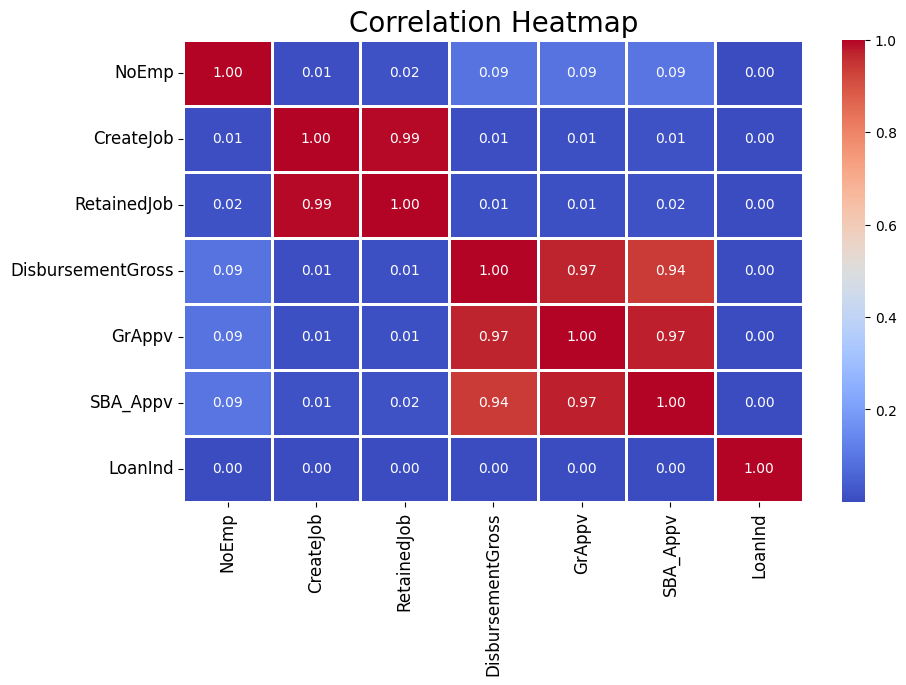

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# set the figure size
plt.figure(figsize=(10,6))

# create a heatmap of the correlations
sns.heatmap(df[num_columns].corr(), cmap='coolwarm', annot=True, fmt='.2f', linewidths=1)

# set the title and font size
plt.title('Correlation Heatmap', fontsize=20)

# set the tick label font size
plt.tick_params(labelsize=12)

# show the plot
plt.show()

### Adding features in Train, Validation and Test set

Based on the above correlation matrix and domain knowledge, below features are created 

In [22]:
# Adding engineered features in training data

#ratio represents the percentage of the total loan amount that is guaranteed by the SBA
X_train['ApprovalRatio'] = np.where(X_train['GrAppv'] == 0, 0, X_train['SBA_Appv'] / X_train['GrAppv'])

# the average number of employees per job created
X_train['EmpPerCreateJob'] = np.where(X_train['CreateJob'] == 0, 0, X_train['NoEmp'] / X_train['CreateJob'])

# average number of employees per job retained
X_train['EmpPerRetainedJob'] = np.where(X_train['RetainedJob'] == 0, 0, X_train['NoEmp'] / X_train['RetainedJob'])

# percentage of the approved loan amount that was actually disbursed
X_train['DisbursementRatio'] = np.where(X_train['GrAppv'] == 0, 0, X_train['DisbursementGross'] / X_train['GrAppv'])

# percentage of the disbursed amount that is guaranteed by the SBA
X_train['SBA_AppvRatio'] = np.where(X_train['DisbursementGross'] == 0, 0, X_train['SBA_Appv'] / X_train['DisbursementGross'])

# Total number of Jobs for businesses
X_train['TotalJobs'] = X_train['CreateJob'] + X_train['RetainedJob']

# ratio of the disbursement amount to the amount approved by the SBA
X_train['Disbursement_to_Appv_ratio'] = np.where(X_train['SBA_Appv'] == 0, 0, X_train['DisbursementGross'] / X_train['SBA_Appv'])

# measure of how much of the loan has been paid off so far
X_train['NetDisbursement'] = np.where(X_train['BalanceGross'] == 0, 0, X_train['DisbursementGross'] / X_train['BalanceGross'])

# feature indicating the average amount of disbursement gross per employee
X_train['DisbursementGross_per_employee'] = np.where(X_train['NoEmp'] == 0, 0, X_train['DisbursementGross'] / X_train['NoEmp'])
    
# feature indicating the average amount of net disbursement per employee
X_train['DisbursementNet_per_employee'] = np.where(X_train['NoEmp'] == 0, 0, X_train['NetDisbursement'] / X_train['NoEmp'])


In [23]:
print()
X_train.head(2)

,City,State,Zip,Bank,BankState,NAICS,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,DisbursementGross,BalanceGross,GrAppv,SBA_Appv,LoanInd,City_tr,State_tr,Bank_tr,BankState_tr,RevLineCr_tr,LowDoc_tr,ApprovalRatio,EmpPerCreateJob,EmpPerRetainedJob,DisbursementRatio,SBA_AppvRatio,TotalJobs,Disbursement_to_Appv_ratio,NetDisbursement,DisbursementGross_per_employee,DisbursementNet_per_employee
660705,SUSSEX,WI,53089,U.S. BANK NATIONAL ASSOCIATION,WI,333512,1,2.0,0,0,1,0,N,Y,100000.0,0.0,100000.0,80000.0,3,0.116539,0.117814,0.173724,0.115492,0.146808,0.089707,0.8,0.0,0.0,1.000000,0.800000,0,1.250000,0.0,100000.0,0.0
489443,BELLE VERNON,PA,15012,"PNC BANK, NATIONAL ASSOCIATION",DE,541211,1,1.0,1,1,1,1,Y,N,95048.0,0.0,35000.0,17500.0,4,0.151119,0.149039,0.194693,0.254314,0.254580,0.187415,0.5,1.0,1.0,2.715657,0.184117,2,5.431314,0.0,95048.0,0.0


### Adding the above features in Validation and Test datasets

In [24]:
import numpy as np

# define the list of feature names to be engineered
feature_names = ['ApprovalRatio', 'EmpPerCreateJob', 'EmpPerRetainedJob', 
                 'DisbursementRatio', 'SBA_AppvRatio', 'TotalJobs', 
                 'Disbursement_to_Appv_ratio', 'NetDisbursement', 
                 'DisbursementGross_per_employee', 'DisbursementNet_per_employee']

# iterate over the three dataframes (df1, df2, df3)
for df in [X_val, X_test]:
    for feature_name in feature_names:
        if feature_name == 'ApprovalRatio':
            df[feature_name] = np.where(df['GrAppv'] == 0, 0, df['SBA_Appv'] / df['GrAppv'])
        elif feature_name == 'EmpPerCreateJob':
            df[feature_name] = np.where(df['CreateJob'] == 0, 0, df['NoEmp'] / df['CreateJob'])
        elif feature_name == 'EmpPerRetainedJob':
            df[feature_name] = np.where(df['RetainedJob'] == 0, 0, df['NoEmp'] / df['RetainedJob'])
        elif feature_name == 'DisbursementRatio':
            df[feature_name] = np.where(df['GrAppv'] == 0, 0, df['DisbursementGross'] / df['GrAppv'])
        elif feature_name == 'SBA_AppvRatio':
            df[feature_name] = np.where(df['DisbursementGross'] == 0, 0, df['SBA_Appv'] / df['DisbursementGross'])
        elif feature_name == 'TotalJobs':
            df[feature_name] = df['CreateJob'] + df['RetainedJob']
        elif feature_name == 'Disbursement_to_Appv_ratio':
            df[feature_name] = np.where(df['SBA_Appv'] == 0, 0, df['DisbursementGross'] / df['SBA_Appv'])
        elif feature_name == 'NetDisbursement':
            df[feature_name] = np.where(df['BalanceGross'] == 0, 0, df['DisbursementGross'] / df['BalanceGross'])
        elif feature_name == 'DisbursementGross_per_employee':
            df[feature_name] = np.where(df['NoEmp'] == 0, 0, df['DisbursementGross'] / df['NoEmp'])
        elif feature_name == 'DisbursementNet_per_employee':
            df[feature_name] = np.where(df['NoEmp'] == 0, 0, df['NetDisbursement'] / df['NoEmp'])


### Peaking at the prepared data

In [25]:
X_val.head(2)

,City,State,Zip,Bank,BankState,NAICS,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,DisbursementGross,BalanceGross,GrAppv,SBA_Appv,LoanInd,City_tr,State_tr,Bank_tr,BankState_tr,RevLineCr_tr,LowDoc_tr,ApprovalRatio,EmpPerCreateJob,EmpPerRetainedJob,DisbursementRatio,SBA_AppvRatio,TotalJobs,Disbursement_to_Appv_ratio,NetDisbursement,DisbursementGross_per_employee,DisbursementNet_per_employee
521853,FOSSTON,MN,56542,CAPITAL ONE NATL ASSOC,VA,722110,11,1.0,2,11,1,1,0,N,25000.0,0.0,25000.0,12500.0,3,0.117353,0.114422,0.413226,0.383858,0.149638,0.187415,0.5,5.5,1.000000,1.0,0.5,13,2.0,0.0,2272.727273,0.0
412632,PARSIPPANY,NJ,7054,FULTON BANK OF NEW JERSEY,NJ,541613,4,1.0,2,6,1,1,0,N,25000.0,0.0,25000.0,12500.0,8,0.149045,0.202825,0.130137,0.091426,0.149638,0.187415,0.5,2.0,0.666667,1.0,0.5,8,2.0,0.0,6250.000000,0.0


In [26]:
X_test.head(2)

,City,State,Zip,Bank,BankState,NAICS,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,DisbursementGross,BalanceGross,GrAppv,SBA_Appv,LoanInd,City_tr,State_tr,Bank_tr,BankState_tr,RevLineCr_tr,LowDoc_tr,ApprovalRatio,EmpPerCreateJob,EmpPerRetainedJob,DisbursementRatio,SBA_AppvRatio,TotalJobs,Disbursement_to_Appv_ratio,NetDisbursement,DisbursementGross_per_employee,DisbursementNet_per_employee
784240,EAST ELMHURST,NY,11369,BANK OF AMERICA NATL ASSOC,NC,811111,5,1.0,1,5,0,1,N,N,35000.0,0.0,35000.0,17500.0,6,0.236165,0.198780,0.275820,0.293019,0.146808,0.187415,0.5,5.00,1.0,1.0,0.5,6,2.0,0.0,7000.00000,0.0
603149,MADISON LAKE,MN,56063,PRAIRIELAND ECONOMIC DEVEL COR,MN,332312,27,1.0,4,27,1,2,0,N,125000.0,0.0,125000.0,125000.0,6,0.141117,0.114422,0.000065,0.073605,0.149638,0.187415,1.0,6.75,1.0,1.0,1.0,31,1.0,0.0,4629.62963,0.0


# ** Model Training ** : Setting Baseline models 

## Data Preparation for model building

#### Converting variables to categorical factors

This is only needed for Sklearn API

In [27]:
# Converting variables in Original Dataset
for column in orig_categorical_columns:
    X_train_org[column] = X_train_org[column].astype('category')
    X_val_org[column] = X_val_org[column].astype('category')
    X_test_org[column] = X_test_org[column].astype('category')


# Converting variables in Modified Dataset    
for column in orig_categorical_columns:
    X_train[column] = X_train[column].astype('category')
    X_val[column] = X_val[column].astype('category')
    X_test[column] = X_test[column].astype('category')

orig_categorical_columns

['City', 'State', 'Bank', 'BankState', 'RevLineCr', 'LowDoc']

###  Original Dataset - without any encoding & Feature engineering looks like this:

In [28]:
X_val_org.head(1)

,index,City,State,Zip,Bank,BankState,NAICS,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,DisbursementGross,BalanceGross,GrAppv,SBA_Appv,LoanInd
521853,521853,FOSSTON,MN,56542,CAPITAL ONE NATL ASSOC,VA,722110,11,1.0,2,11,1,1,0,N,25000.0,0.0,25000.0,12500.0,3


In [29]:
X_train_org.head(1)

,index,City,State,Zip,Bank,BankState,NAICS,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,DisbursementGross,BalanceGross,GrAppv,SBA_Appv,LoanInd
660705,660705,SUSSEX,WI,53089,U.S. BANK NATIONAL ASSOCIATION,WI,333512,1,2.0,0,0,1,0,N,Y,100000.0,0.0,100000.0,80000.0,3


##  ** LightGBM Training**

This model is build on original train and Validation dataset with encoded and engineered features

### Building Baseline model - LighGBM

In [30]:
import lightgbm as lgb

train_data = lgb.Dataset(data=X_train, label=y_train, categorical_feature=orig_categorical_columns)
val_data = lgb.Dataset(data=X_val, label=y_val, categorical_feature=orig_categorical_columns)
lgb_clf = lgb.train(params={}, train_set=train_data)


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.052991 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15384
[LightGBM] [Info] Number of data points in the train set: 484470, number of used features: 32
[LightGBM] [Info] Start training from score 0.175916


**Evaluation matrix for Baseline LighGBM model**

In [31]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score

print("AUC score on Validation dataset:", roc_auc_score(y_val, lgb_clf.predict(X_val)))
print("AUC score on Train dataset:", roc_auc_score(y_train, lgb_clf.predict(X_train)))

# Get predicted probabilities of positive class
y_pred_prob = lgb_clf.predict(X_val)
# Get predicted probabilities on train set
y_train_pred_prob = lgb_clf.predict(X_train)

# Calculate AUCPR on VAlidation and train set
print("\nAUCPR score on Validation dataset:", average_precision_score(y_val, y_pred_prob, pos_label=1))
print("AUCPR on train set:",  average_precision_score(y_train, y_train_pred_prob))

AUC score on Validation dataset: 0.8264384046206024
AUC score on Train dataset: 0.8776365497223705

AUCPR score on Validation dataset: 0.5443572978694184
AUCPR on train set: 0.6512293885366858


## ---------------------------------------------- Concluding Model Training - LighGBM  ---------------------------------------------- ##

#### Now we have to compete with these train and validation set AUC and AUCPR scores:

- AUC score on Test dataset: 0.8264384046206024
- AUC score on Train dataset: 0.8776365497223705


- AUCPR score on Validation dataset: 0.5443572978694184
- AUCPR on train set: 0.6512293885366858

***We are using these scores as the class is highly imbalanced***




## ** GBM (H2O) Training**

In [32]:
import h2o
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.grid.grid_search import H2OGridSearch
h2o.init(nthreads=-1, strict_version_check=True)

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; OpenJDK 64-Bit Server VM (build 19.0.1+10-21, mixed mode, sharing)
  Starting server from C:\Users\rechi\OneDrive\Desktop\UTD\Sem 2\BUAN 6341 Machine Learning\Python\virtualenvn\ml-spring-2023\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\rechi\AppData\Local\Temp\tmp5ht57o0r
  JVM stdout: C:\Users\rechi\AppData\Local\Temp\tmp5ht57o0r\h2o_rechi_started_from_python.out
  JVM stderr: C:\Users\rechi\AppData\Local\Temp\tmp5ht57o0r\h2o_rechi_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,04 secs
H2O_cluster_timezone:,America/Chicago
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.40.0.3
H2O_cluster_version_age:,1 month and 3 days
H2O_cluster_name:,H2O_from_python_rechi_g1hoiv
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.957 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


### Converting Dataframes to H2o frames

In [33]:
%%time

# conversion to H2o dataset:
## Original Dataset
h2o_X_train_org = h2o.H2OFrame(X_train_org)
h2o_X_val_org = h2o.H2OFrame(X_val_org)
h2o_X_test_org = h2o.H2OFrame(X_test_org)

#Transformed Dataset
h2o_X_train = h2o.H2OFrame(X_train)
h2o_X_val = h2o.H2OFrame(X_val)
h2o_X_test = h2o.H2OFrame(X_test)

# convert the series to a pandas dataframe and then to H2o
##train set
h2o_y_train = pd.DataFrame(y_train)
h2o_y_train = h2o.H2OFrame(h2o_y_train)

## validation set
h2o_y_val = pd.DataFrame(y_val)
h2o_y_val = h2o.H2OFrame(h2o_y_val)

## Test set
h2o_y_test = pd.DataFrame(y_test)
h2o_y_test = h2o.H2OFrame(h2o_y_test)


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
CPU times: total: 31.7 s
Wall time: 59.2 s


**Setting predictors and response variable**

In [34]:
# predictors = [x for x in X_train_org.select_dtypes(include=np.number).columns if x not in ['MIS_Status','index']]
predictors = [x for x in X_train.columns if x not in ['MIS_Status','index']]
response = 'MIS_Status'

h2o_y_train[response] = h2o_y_train[response].asfactor()

**Building the GBM model with defaul parameters**

In [112]:

#We only provide the required parameters, everything else is default
gbm = H2OGradientBoostingEstimator();
gbm.train(x=predictors, y=response, training_frame=h2o_X_train.cbind(h2o_y_train));

## Show a detailed model summary
print(gbm);

gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Model Details
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_model_python_1683405108126_29


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    50                 50                          27557                  5            5            5             26            32            31.38

ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.10780628782728902
RMSE: 0.32833867854288656
LogLoss: 0.3505353013687365
Mean Per-Class Error: 0.2667340338960016
AUC: 0.8300210567398381
AUCPR: 0.5650940065150096
Gini: 0.6600421134796761

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2600

**Performance evaluation metrics**

In [113]:
## Get the AUC on the validation set
perf = gbm.model_performance(h2o_X_val_org.cbind(h2o_y_val))

print('AUC for baseline GBM model on validation set: ',perf.auc())
print('AUCPR for baseline GBM model on validation set: ',gbm.model_performance(h2o_X_val_org.cbind(h2o_y_val)).aucpr())

AUC for baseline GBM model on validation set:  0.6956198936122354
AUCPR for baseline GBM model on validation set:  0.2974643000545165


## ---------------------------------------------- Concluding Model Training - GBM (H2O)  ---------------------------------------------- ##

*We now have our baseline AUC value for GBM model, with default parameters and no feature engineering applied*

- AUC for baseline GBM model on validation set:  0.6956198936122354

- AUCPR for baseline GBM model on validation set:  0.2974643000545165

# ** Model Tuning **

##  ** LightGBM Tuning**

In [124]:
# !pip install optuna

In [36]:
%%time

import optuna.integration.lightgbm as lgb_optuna
from optuna.integration import LightGBMPruningCallback
import tqdm as notebook_tqdm
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import optuna
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
study_model_iteractions = {}

def objective(trial, X, y):
    param_grid = {
        # Refer to the Official guide : https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html
        "num_iterations": 10000,
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, step=0.05),
        "num_leaves": trial.suggest_int("num_leaves", 50, 150, step=5),
        "max_depth": trial.suggest_int("max_depth", 5, 20, step=2),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 100, 1000, step=100),
        ##############################
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        ########################
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.8, 1.0, step=0.1),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [5]),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.8, 1.0, step=0.1),
        #######################
        "is_unbalance": trial.suggest_categorical("is_unbalance",[True, False]),
        ########################
        "verbose": -1,
        "objective":"binary",
        "metric":"auc"
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1121218)

    cv_scores = np.empty(5)
    cv_iteractions = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_valid = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[test_idx]

        train_data = lgb.Dataset(data=X_train, label=y_train, params={"verbose":-1}, categorical_feature=orig_categorical_columns)
        valid_data = lgb.Dataset(data=X_valid, label=y_valid, params={"verbose":-1}, categorical_feature=orig_categorical_columns)
        lgb_clf = lgb.train(params=param_grid,
                            train_set=train_data,
                            valid_sets=[valid_data],
                            categorical_feature=orig_categorical_columns,
                            callbacks=[LightGBMPruningCallback(trial, "auc"),
                                        lgb.early_stopping(stopping_rounds=5)]  
                            )
        preds = lgb_clf.predict(X_valid)
        cv_scores[idx] = roc_auc_score(y_valid, preds)
        cv_iteractions[idx] = lgb_clf.best_iteration
    
    study_model_iteractions[trial.number] = np.mean(cv_iteractions)

    return np.mean(cv_scores)

CPU times: total: 109 ms
Wall time: 3.71 s


In [37]:
%%time

study = optuna.create_study(direction="maximize", study_name="LGBM Classifier")
func = lambda trial: objective(trial, X_train, y_train)
study.optimize(func, n_trials=200)

[I 2023-05-07 11:58:16,605] A new study created in memory with name: LGBM Classifier


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[49]	valid_0's auc: 0.847225
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[45]	valid_0's auc: 0.847717
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[48]	valid_0's auc: 0.849146
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[33]	valid_0's auc: 0.847233
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[41]	valid_0's auc: 0.847796


[I 2023-05-07 11:58:48,535] Trial 0 finished with value: 0.8478234521362115 and parameters: {'learning_rate': 0.16000000000000003, 'num_leaves': 115, 'max_depth': 9, 'min_data_in_leaf': 500, 'lambda_l1': 0.00026152852490577045, 'lambda_l2': 0.0008911034245314149, 'bagging_fraction': 0.9, 'bagging_freq': 5, 'feature_fraction': 1.0, 'is_unbalance': False}. Best is trial 0 with value: 0.8478234521362115.


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[70]	valid_0's auc: 0.85446
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[44]	valid_0's auc: 0.851956
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[65]	valid_0's auc: 0.855567
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[80]	valid_0's auc: 0.853434
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[45]	valid_0's auc: 0.850994


[I 2023-05-07 11:59:20,510] Trial 1 finished with value: 0.8532823987025561 and parameters: {'learning_rate': 0.26, 'num_leaves': 105, 'max_depth': 7, 'min_data_in_leaf': 1000, 'lambda_l1': 1.3953468606171323e-08, 'lambda_l2': 3.7115973893609846e-07, 'bagging_fraction': 0.9, 'bagging_freq': 5, 'feature_fraction': 1.0, 'is_unbalance': True}. Best is trial 1 with value: 0.8532823987025561.


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[22]	valid_0's auc: 0.848218
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[22]	valid_0's auc: 0.851053
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[18]	valid_0's auc: 0.851566
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[22]	valid_0's auc: 0.848958
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[22]	valid_0's auc: 0.850706


[I 2023-05-07 11:59:43,762] Trial 2 finished with value: 0.850100228837318 and parameters: {'learning_rate': 0.26, 'num_leaves': 140, 'max_depth': 11, 'min_data_in_leaf': 100, 'lambda_l1': 1.9097677737383546e-08, 'lambda_l2': 7.542512819209437, 'bagging_fraction': 1.0, 'bagging_freq': 5, 'feature_fraction': 0.8, 'is_unbalance': True}. Best is trial 1 with value: 0.8532823987025561.


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[71]	valid_0's auc: 0.843435
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[80]	valid_0's auc: 0.844146
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[57]	valid_0's auc: 0.845139
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[55]	valid_0's auc: 0.844206
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[69]	valid_0's auc: 0.843548


[I 2023-05-07 12:00:13,731] Trial 3 finished with value: 0.8440947781245722 and parameters: {'learning_rate': 0.16000000000000003, 'num_leaves': 65, 'max_depth': 5, 'min_data_in_leaf': 400, 'lambda_l1': 0.052057893907711004, 'lambda_l2': 0.0001953525907957959, 'bagging_fraction': 0.9, 'bagging_freq': 5, 'feature_fraction': 1.0, 'is_unbalance': False}. Best is trial 1 with value: 0.8532823987025561.


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[22]	valid_0's auc: 0.846135
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[25]	valid_0's auc: 0.848887
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[23]	valid_0's auc: 0.848599
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[25]	valid_0's auc: 0.848909
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[17]	valid_0's auc: 0.847266


[I 2023-05-07 12:00:42,132] Trial 4 finished with value: 0.8479591805766118 and parameters: {'learning_rate': 0.26, 'num_leaves': 95, 'max_depth': 13, 'min_data_in_leaf': 100, 'lambda_l1': 0.08332806434266878, 'lambda_l2': 0.00023540879111857895, 'bagging_fraction': 0.9, 'bagging_freq': 5, 'feature_fraction': 1.0, 'is_unbalance': False}. Best is trial 1 with value: 0.8532823987025561.
[I 2023-05-07 12:00:43,845] Trial 5 pruned. Trial was pruned at iteration 0.


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[68]	valid_0's auc: 0.858922
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[95]	valid_0's auc: 0.860236
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[64]	valid_0's auc: 0.859844
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[85]	valid_0's auc: 0.858594
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[65]	valid_0's auc: 0.858308


[I 2023-05-07 12:01:36,321] Trial 6 finished with value: 0.8591806731894154 and parameters: {'learning_rate': 0.16000000000000003, 'num_leaves': 135, 'max_depth': 15, 'min_data_in_leaf': 800, 'lambda_l1': 0.00018145404397480172, 'lambda_l2': 5.248801439270363e-07, 'bagging_fraction': 1.0, 'bagging_freq': 5, 'feature_fraction': 0.8, 'is_unbalance': False}. Best is trial 6 with value: 0.8591806731894154.
[I 2023-05-07 12:01:37,996] Trial 7 pruned. Trial was pruned at iteration 0.
[I 2023-05-07 12:01:39,715] Trial 8 pruned. Trial was pruned at iteration 0.
[I 2023-05-07 12:01:41,528] Trial 9 pruned. Trial was pruned at iteration 0.


Training until validation scores don't improve for 5 rounds


[I 2023-05-07 12:01:44,038] Trial 10 pruned. Trial was pruned at iteration 7.
[I 2023-05-07 12:01:45,703] Trial 11 pruned. Trial was pruned at iteration 0.
[I 2023-05-07 12:01:47,427] Trial 12 pruned. Trial was pruned at iteration 0.
[I 2023-05-07 12:01:49,182] Trial 13 pruned. Trial was pruned at iteration 0.
[I 2023-05-07 12:01:50,918] Trial 14 pruned. Trial was pruned at iteration 0.
[I 2023-05-07 12:01:52,667] Trial 15 pruned. Trial was pruned at iteration 0.


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[73]	valid_0's auc: 0.860379
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[66]	valid_0's auc: 0.858936
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[42]	valid_0's auc: 0.859161
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[53]	valid_0's auc: 0.858147
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[63]	valid_0's auc: 0.859533


[I 2023-05-07 12:02:30,224] Trial 16 finished with value: 0.8592310439417906 and parameters: {'learning_rate': 0.21000000000000002, 'num_leaves': 150, 'max_depth': 13, 'min_data_in_leaf': 1000, 'lambda_l1': 1.3856717573805164e-05, 'lambda_l2': 5.483596357376615e-06, 'bagging_fraction': 1.0, 'bagging_freq': 5, 'feature_fraction': 0.8, 'is_unbalance': False}. Best is trial 16 with value: 0.8592310439417906.


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[41]	valid_0's auc: 0.856991
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[51]	valid_0's auc: 0.856692
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[63]	valid_0's auc: 0.858323
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[44]	valid_0's auc: 0.855383
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[45]	valid_0's auc: 0.85689


[I 2023-05-07 12:03:06,701] Trial 17 finished with value: 0.8568559480758953 and parameters: {'learning_rate': 0.21000000000000002, 'num_leaves': 150, 'max_depth': 13, 'min_data_in_leaf': 800, 'lambda_l1': 0.00010459443094507836, 'lambda_l2': 8.774295376896036e-06, 'bagging_fraction': 1.0, 'bagging_freq': 5, 'feature_fraction': 0.8, 'is_unbalance': False}. Best is trial 16 with value: 0.8592310439417906.
[I 2023-05-07 12:03:08,354] Trial 18 pruned. Trial was pruned at iteration 1.


Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[81]	valid_0's auc: 0.859866
Training until validation scores don't improve for 5 rounds


[I 2023-05-07 12:03:26,699] Trial 19 pruned. Trial was pruned at iteration 90.


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[42]	valid_0's auc: 0.856014
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[45]	valid_0's auc: 0.856425
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[41]	valid_0's auc: 0.856455
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[49]	valid_0's auc: 0.855746
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[41]	valid_0's auc: 0.854703


[I 2023-05-07 12:04:01,622] Trial 20 finished with value: 0.8558687600814396 and parameters: {'learning_rate': 0.21000000000000002, 'num_leaves': 125, 'max_depth': 17, 'min_data_in_leaf': 700, 'lambda_l1': 4.2597794359831455e-06, 'lambda_l2': 1.1129161765069608e-05, 'bagging_fraction': 1.0, 'bagging_freq': 5, 'feature_fraction': 0.8, 'is_unbalance': False}. Best is trial 16 with value: 0.8592310439417906.


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[41]	valid_0's auc: 0.856991
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[51]	valid_0's auc: 0.856692
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[63]	valid_0's auc: 0.858323
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[44]	valid_0's auc: 0.855383
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[45]	valid_0's auc: 0.85689


[I 2023-05-07 12:04:35,587] Trial 21 finished with value: 0.8568559580683554 and parameters: {'learning_rate': 0.21000000000000002, 'num_leaves': 150, 'max_depth': 13, 'min_data_in_leaf': 800, 'lambda_l1': 0.00013854102065412227, 'lambda_l2': 6.17070373462396e-06, 'bagging_fraction': 1.0, 'bagging_freq': 5, 'feature_fraction': 0.8, 'is_unbalance': False}. Best is trial 16 with value: 0.8592310439417906.


Training until validation scores don't improve for 5 rounds


[I 2023-05-07 12:04:41,726] Trial 22 pruned. Trial was pruned at iteration 56.


Training until validation scores don't improve for 5 rounds


[I 2023-05-07 12:04:43,765] Trial 23 pruned. Trial was pruned at iteration 2.


Training until validation scores don't improve for 5 rounds


[I 2023-05-07 12:04:50,412] Trial 24 pruned. Trial was pruned at iteration 58.
[I 2023-05-07 12:04:52,276] Trial 25 pruned. Trial was pruned at iteration 1.


Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds


[I 2023-05-07 12:04:55,503] Trial 26 pruned. Trial was pruned at iteration 16.
[I 2023-05-07 12:04:57,464] Trial 27 pruned. Trial was pruned at iteration 1.


Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[69]	valid_0's auc: 0.858916
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[54]	valid_0's auc: 0.858259
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[82]	valid_0's auc: 0.860232
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[61]	valid_0's auc: 0.85758
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[44]	valid_0's auc: 0.857139


[I 2023-05-07 12:05:40,195] Trial 28 finished with value: 0.8584249812605964 and parameters: {'learning_rate': 0.21000000000000002, 'num_leaves': 145, 'max_depth': 17, 'min_data_in_leaf': 800, 'lambda_l1': 0.0005920626011575768, 'lambda_l2': 4.046845980909917e-06, 'bagging_fraction': 1.0, 'bagging_freq': 5, 'feature_fraction': 0.8, 'is_unbalance': False}. Best is trial 16 with value: 0.8592310439417906.
[I 2023-05-07 12:05:41,963] Trial 29 pruned. Trial was pruned at iteration 0.
[I 2023-05-07 12:05:43,721] Trial 30 pruned. Trial was pruned at iteration 0.


Training until validation scores don't improve for 5 rounds


[I 2023-05-07 12:05:48,743] Trial 31 pruned. Trial was pruned at iteration 35.


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[68]	valid_0's auc: 0.860027
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[99]	valid_0's auc: 0.860792
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[87]	valid_0's auc: 0.861658
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[71]	valid_0's auc: 0.859287
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[58]	valid_0's auc: 0.859174


[I 2023-05-07 12:06:35,359] Trial 32 finished with value: 0.8601874965787382 and parameters: {'learning_rate': 0.21000000000000002, 'num_leaves': 135, 'max_depth': 15, 'min_data_in_leaf': 1000, 'lambda_l1': 6.357436452004147e-05, 'lambda_l2': 3.0477500894320936e-07, 'bagging_fraction': 1.0, 'bagging_freq': 5, 'feature_fraction': 0.8, 'is_unbalance': False}. Best is trial 32 with value: 0.8601874965787382.


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[58]	valid_0's auc: 0.858919
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[66]	valid_0's auc: 0.858732
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[58]	valid_0's auc: 0.859921
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[67]	valid_0's auc: 0.858449
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[59]	valid_0's auc: 0.858011


[I 2023-05-07 12:07:19,132] Trial 33 finished with value: 0.858806464546469 and parameters: {'learning_rate': 0.26, 'num_leaves': 130, 'max_depth': 19, 'min_data_in_leaf': 1000, 'lambda_l1': 2.9539958506869683e-05, 'lambda_l2': 2.632980647164491e-07, 'bagging_fraction': 1.0, 'bagging_freq': 5, 'feature_fraction': 0.8, 'is_unbalance': False}. Best is trial 32 with value: 0.8601874965787382.


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[49]	valid_0's auc: 0.858029
Training until validation scores don't improve for 5 rounds


[I 2023-05-07 12:07:34,024] Trial 34 pruned. Trial was pruned at iteration 64.
[I 2023-05-07 12:07:35,753] Trial 35 pruned. Trial was pruned at iteration 0.
[I 2023-05-07 12:07:37,800] Trial 36 pruned. Trial was pruned at iteration 0.
[I 2023-05-07 12:07:39,987] Trial 37 pruned. Trial was pruned at iteration 1.


Training until validation scores don't improve for 5 rounds


[I 2023-05-07 12:07:41,795] Trial 38 pruned. Trial was pruned at iteration 0.
[I 2023-05-07 12:07:43,491] Trial 39 pruned. Trial was pruned at iteration 0.
[I 2023-05-07 12:07:45,209] Trial 40 pruned. Trial was pruned at iteration 0.


Training until validation scores don't improve for 5 rounds


[I 2023-05-07 12:07:53,324] Trial 41 pruned. Trial was pruned at iteration 68.


Training until validation scores don't improve for 5 rounds


[I 2023-05-07 12:07:55,252] Trial 42 pruned. Trial was pruned at iteration 2.
[I 2023-05-07 12:07:57,085] Trial 43 pruned. Trial was pruned at iteration 0.


Training until validation scores don't improve for 5 rounds


[I 2023-05-07 12:08:02,473] Trial 44 pruned. Trial was pruned at iteration 40.
[I 2023-05-07 12:08:04,342] Trial 45 pruned. Trial was pruned at iteration 0.
[I 2023-05-07 12:08:06,110] Trial 46 pruned. Trial was pruned at iteration 0.
[I 2023-05-07 12:08:08,056] Trial 47 pruned. Trial was pruned at iteration 1.


Training until validation scores don't improve for 5 rounds


[I 2023-05-07 12:08:11,700] Trial 48 pruned. Trial was pruned at iteration 0.
[I 2023-05-07 12:08:13,396] Trial 49 pruned. Trial was pruned at iteration 0.
[I 2023-05-07 12:08:15,122] Trial 50 pruned. Trial was pruned at iteration 0.


Training until validation scores don't improve for 5 rounds


[I 2023-05-07 12:08:19,864] Trial 51 pruned. Trial was pruned at iteration 31.


Training until validation scores don't improve for 5 rounds


[I 2023-05-07 12:08:27,475] Trial 52 pruned. Trial was pruned at iteration 73.
[I 2023-05-07 12:08:29,347] Trial 53 pruned. Trial was pruned at iteration 1.


Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds


[I 2023-05-07 12:08:31,263] Trial 54 pruned. Trial was pruned at iteration 2.
[I 2023-05-07 12:08:32,972] Trial 55 pruned. Trial was pruned at iteration 0.
[I 2023-05-07 12:08:34,802] Trial 56 pruned. Trial was pruned at iteration 0.
[I 2023-05-07 12:08:36,494] Trial 57 pruned. Trial was pruned at iteration 0.
[I 2023-05-07 12:08:38,143] Trial 58 pruned. Trial was pruned at iteration 0.
[I 2023-05-07 12:08:39,951] Trial 59 pruned. Trial was pruned at iteration 0.
[I 2023-05-07 12:08:41,598] Trial 60 pruned. Trial was pruned at iteration 0.


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[41]	valid_0's auc: 0.856991
Training until validation scores don't improve for 5 rounds


[I 2023-05-07 12:10:48,020] Trial 61 pruned. Trial was pruned at iteration 54.
[I 2023-05-07 12:10:49,221] Trial 62 pruned. Trial was pruned at iteration 0.


Training until validation scores don't improve for 5 rounds


[I 2023-05-07 12:10:52,387] Trial 63 pruned. Trial was pruned at iteration 28.
[I 2023-05-07 12:10:53,460] Trial 64 pruned. Trial was pruned at iteration 0.


Training until validation scores don't improve for 5 rounds


[I 2023-05-07 12:10:57,871] Trial 65 pruned. Trial was pruned at iteration 31.


Training until validation scores don't improve for 5 rounds


[I 2023-05-07 12:11:00,116] Trial 66 pruned. Trial was pruned at iteration 2.


Training until validation scores don't improve for 5 rounds


[I 2023-05-07 12:11:02,271] Trial 67 pruned. Trial was pruned at iteration 2.


Training until validation scores don't improve for 5 rounds


[I 2023-05-07 12:11:05,100] Trial 68 pruned. Trial was pruned at iteration 19.
[I 2023-05-07 12:11:06,294] Trial 69 pruned. Trial was pruned at iteration 0.


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[68]	valid_0's auc: 0.860027
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[72]	valid_0's auc: 0.860032
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[101]	valid_0's auc: 0.861871
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[56]	valid_0's auc: 0.85874
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[67]	valid_0's auc: 0.859597


[I 2023-05-07 12:11:37,737] Trial 70 finished with value: 0.860053358961945 and parameters: {'learning_rate': 0.21000000000000002, 'num_leaves': 135, 'max_depth': 15, 'min_data_in_leaf': 1000, 'lambda_l1': 1.9914123831922946e-05, 'lambda_l2': 1.2377302179542805e-07, 'bagging_fraction': 1.0, 'bagging_freq': 5, 'feature_fraction': 0.8, 'is_unbalance': False}. Best is trial 32 with value: 0.8601874965787382.


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[68]	valid_0's auc: 0.860027
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[72]	valid_0's auc: 0.860032
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[101]	valid_0's auc: 0.861871
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[56]	valid_0's auc: 0.85874
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[86]	valid_0's auc: 0.860068


[I 2023-05-07 12:12:12,065] Trial 71 finished with value: 0.8601475442791029 and parameters: {'learning_rate': 0.21000000000000002, 'num_leaves': 135, 'max_depth': 15, 'min_data_in_leaf': 1000, 'lambda_l1': 2.4530001557626207e-05, 'lambda_l2': 1.1362691789066762e-07, 'bagging_fraction': 1.0, 'bagging_freq': 5, 'feature_fraction': 0.8, 'is_unbalance': False}. Best is trial 32 with value: 0.8601874965787382.
[I 2023-05-07 12:12:13,927] Trial 72 pruned. Trial was pruned at iteration 1.


Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[68]	valid_0's auc: 0.860027
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[72]	valid_0's auc: 0.860032
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[81]	valid_0's auc: 0.861762
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[56]	valid_0's auc: 0.85874
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[67]	valid_0's auc: 0.859597


[I 2023-05-07 12:12:57,842] Trial 73 finished with value: 0.8600315853909766 and parameters: {'learning_rate': 0.21000000000000002, 'num_leaves': 135, 'max_depth': 15, 'min_data_in_leaf': 1000, 'lambda_l1': 1.0461160318180545e-05, 'lambda_l2': 1.5538168713119266e-07, 'bagging_fraction': 1.0, 'bagging_freq': 5, 'feature_fraction': 0.8, 'is_unbalance': False}. Best is trial 32 with value: 0.8601874965787382.


Training until validation scores don't improve for 5 rounds


[I 2023-05-07 12:12:59,827] Trial 74 pruned. Trial was pruned at iteration 2.
[I 2023-05-07 12:13:01,581] Trial 75 pruned. Trial was pruned at iteration 0.
[I 2023-05-07 12:13:03,394] Trial 76 pruned. Trial was pruned at iteration 1.


Training until validation scores don't improve for 5 rounds


[I 2023-05-07 12:13:05,166] Trial 77 pruned. Trial was pruned at iteration 0.
[I 2023-05-07 12:13:07,050] Trial 78 pruned. Trial was pruned at iteration 1.


Training until validation scores don't improve for 5 rounds


[I 2023-05-07 12:13:08,749] Trial 79 pruned. Trial was pruned at iteration 0.
[I 2023-05-07 12:13:10,654] Trial 80 pruned. Trial was pruned at iteration 1.


Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds


[I 2023-05-07 12:13:12,668] Trial 81 pruned. Trial was pruned at iteration 2.


Training until validation scores don't improve for 5 rounds


[I 2023-05-07 12:13:20,643] Trial 82 pruned. Trial was pruned at iteration 72.


Training until validation scores don't improve for 5 rounds


[I 2023-05-07 12:13:22,689] Trial 83 pruned. Trial was pruned at iteration 2.


Training until validation scores don't improve for 5 rounds


[I 2023-05-07 12:13:32,097] Trial 84 pruned. Trial was pruned at iteration 85.


Training until validation scores don't improve for 5 rounds


[I 2023-05-07 12:13:35,974] Trial 85 pruned. Trial was pruned at iteration 18.
[I 2023-05-07 12:13:37,695] Trial 86 pruned. Trial was pruned at iteration 0.
[I 2023-05-07 12:13:39,587] Trial 87 pruned. Trial was pruned at iteration 0.


Training until validation scores don't improve for 5 rounds


[I 2023-05-07 12:13:41,549] Trial 88 pruned. Trial was pruned at iteration 2.


Training until validation scores don't improve for 5 rounds


[I 2023-05-07 12:13:43,484] Trial 89 pruned. Trial was pruned at iteration 2.


Training until validation scores don't improve for 5 rounds


[I 2023-05-07 12:13:45,521] Trial 90 pruned. Trial was pruned at iteration 2.


Training until validation scores don't improve for 5 rounds


[I 2023-05-07 12:13:47,549] Trial 91 pruned. Trial was pruned at iteration 3.


Training until validation scores don't improve for 5 rounds


[I 2023-05-07 12:13:49,781] Trial 92 pruned. Trial was pruned at iteration 4.


Training until validation scores don't improve for 5 rounds


[I 2023-05-07 12:13:51,933] Trial 93 pruned. Trial was pruned at iteration 3.


Training until validation scores don't improve for 5 rounds


[I 2023-05-07 12:13:53,843] Trial 94 pruned. Trial was pruned at iteration 2.


Training until validation scores don't improve for 5 rounds


[I 2023-05-07 12:13:56,186] Trial 95 pruned. Trial was pruned at iteration 6.


Training until validation scores don't improve for 5 rounds


[I 2023-05-07 12:14:01,009] Trial 96 pruned. Trial was pruned at iteration 31.
[I 2023-05-07 12:14:02,711] Trial 97 pruned. Trial was pruned at iteration 0.
[I 2023-05-07 12:14:04,578] Trial 98 pruned. Trial was pruned at iteration 0.
[I 2023-05-07 12:14:06,304] Trial 99 pruned. Trial was pruned at iteration 0.
[I 2023-05-07 12:14:08,186] Trial 100 pruned. Trial was pruned at iteration 1.


Training until validation scores don't improve for 5 rounds


[I 2023-05-07 12:14:10,095] Trial 101 pruned. Trial was pruned at iteration 0.
[I 2023-05-07 12:14:11,807] Trial 102 pruned. Trial was pruned at iteration 0.
[I 2023-05-07 12:14:13,649] Trial 103 pruned. Trial was pruned at iteration 1.


Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds


[I 2023-05-07 12:14:15,774] Trial 104 pruned. Trial was pruned at iteration 3.
[I 2023-05-07 12:14:17,513] Trial 105 pruned. Trial was pruned at iteration 0.


Training until validation scores don't improve for 5 rounds


[I 2023-05-07 12:14:19,430] Trial 106 pruned. Trial was pruned at iteration 2.


Training until validation scores don't improve for 5 rounds


[I 2023-05-07 12:14:21,865] Trial 107 pruned. Trial was pruned at iteration 6.
[I 2023-05-07 12:14:23,705] Trial 108 pruned. Trial was pruned at iteration 1.


Training until validation scores don't improve for 5 rounds


[I 2023-05-07 12:14:25,522] Trial 109 pruned. Trial was pruned at iteration 1.


Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds


[I 2023-05-07 12:14:28,035] Trial 110 pruned. Trial was pruned at iteration 6.
[I 2023-05-07 12:14:29,770] Trial 111 pruned. Trial was pruned at iteration 0.
[I 2023-05-07 12:14:31,537] Trial 112 pruned. Trial was pruned at iteration 0.
[I 2023-05-07 12:14:33,383] Trial 113 pruned. Trial was pruned at iteration 0.
[I 2023-05-07 12:14:35,178] Trial 114 pruned. Trial was pruned at iteration 0.
[I 2023-05-07 12:14:36,916] Trial 115 pruned. Trial was pruned at iteration 0.


Training until validation scores don't improve for 5 rounds


[I 2023-05-07 12:14:39,097] Trial 116 pruned. Trial was pruned at iteration 2.
[I 2023-05-07 12:14:40,806] Trial 117 pruned. Trial was pruned at iteration 0.
[I 2023-05-07 12:14:42,589] Trial 118 pruned. Trial was pruned at iteration 0.
[I 2023-05-07 12:14:44,386] Trial 119 pruned. Trial was pruned at iteration 0.
[I 2023-05-07 12:14:46,243] Trial 120 pruned. Trial was pruned at iteration 1.


Training until validation scores don't improve for 5 rounds


[I 2023-05-07 12:14:47,959] Trial 121 pruned. Trial was pruned at iteration 0.
[I 2023-05-07 12:14:49,757] Trial 122 pruned. Trial was pruned at iteration 0.
[I 2023-05-07 12:14:51,427] Trial 123 pruned. Trial was pruned at iteration 0.
[I 2023-05-07 12:14:53,136] Trial 124 pruned. Trial was pruned at iteration 0.


Training until validation scores don't improve for 5 rounds


[I 2023-05-07 12:14:58,829] Trial 125 pruned. Trial was pruned at iteration 37.


Training until validation scores don't improve for 5 rounds


[I 2023-05-07 12:15:01,291] Trial 126 pruned. Trial was pruned at iteration 6.
[I 2023-05-07 12:15:03,055] Trial 127 pruned. Trial was pruned at iteration 0.
[I 2023-05-07 12:15:04,789] Trial 128 pruned. Trial was pruned at iteration 0.


Training until validation scores don't improve for 5 rounds


[I 2023-05-07 12:15:07,309] Trial 129 pruned. Trial was pruned at iteration 6.
[I 2023-05-07 12:15:09,211] Trial 130 pruned. Trial was pruned at iteration 1.


Training until validation scores don't improve for 5 rounds


[I 2023-05-07 12:15:12,749] Trial 131 pruned. Trial was pruned at iteration 0.
[I 2023-05-07 12:15:14,705] Trial 132 pruned. Trial was pruned at iteration 0.
[I 2023-05-07 12:15:16,732] Trial 133 pruned. Trial was pruned at iteration 0.
[I 2023-05-07 12:15:18,522] Trial 134 pruned. Trial was pruned at iteration 0.
[I 2023-05-07 12:15:20,366] Trial 135 pruned. Trial was pruned at iteration 1.


Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds


[I 2023-05-07 12:15:22,503] Trial 136 pruned. Trial was pruned at iteration 2.
[I 2023-05-07 12:15:24,232] Trial 137 pruned. Trial was pruned at iteration 0.


Training until validation scores don't improve for 5 rounds


[I 2023-05-07 12:15:29,086] Trial 138 pruned. Trial was pruned at iteration 35.
[I 2023-05-07 12:15:31,051] Trial 139 pruned. Trial was pruned at iteration 0.
[I 2023-05-07 12:15:33,130] Trial 140 pruned. Trial was pruned at iteration 0.
[I 2023-05-07 12:15:34,937] Trial 141 pruned. Trial was pruned at iteration 0.
[I 2023-05-07 12:15:36,679] Trial 142 pruned. Trial was pruned at iteration 0.
[I 2023-05-07 12:15:38,494] Trial 143 pruned. Trial was pruned at iteration 0.
[I 2023-05-07 12:15:40,339] Trial 144 pruned. Trial was pruned at iteration 0.
[I 2023-05-07 12:15:42,253] Trial 145 pruned. Trial was pruned at iteration 1.


Training until validation scores don't improve for 5 rounds


[I 2023-05-07 12:15:44,053] Trial 146 pruned. Trial was pruned at iteration 0.
[I 2023-05-07 12:15:45,998] Trial 147 pruned. Trial was pruned at iteration 0.


Training until validation scores don't improve for 5 rounds


[I 2023-05-07 12:15:48,088] Trial 148 pruned. Trial was pruned at iteration 2.
[I 2023-05-07 12:15:49,841] Trial 149 pruned. Trial was pruned at iteration 0.


Training until validation scores don't improve for 5 rounds


[I 2023-05-07 12:15:51,870] Trial 150 pruned. Trial was pruned at iteration 2.
[I 2023-05-07 12:15:53,606] Trial 151 pruned. Trial was pruned at iteration 0.
[I 2023-05-07 12:15:55,331] Trial 152 pruned. Trial was pruned at iteration 0.
[I 2023-05-07 12:15:57,134] Trial 153 pruned. Trial was pruned at iteration 0.
[I 2023-05-07 12:15:58,860] Trial 154 pruned. Trial was pruned at iteration 0.
[I 2023-05-07 12:16:00,577] Trial 155 pruned. Trial was pruned at iteration 0.
[I 2023-05-07 12:16:02,397] Trial 156 pruned. Trial was pruned at iteration 0.
[I 2023-05-07 12:16:04,238] Trial 157 pruned. Trial was pruned at iteration 1.


Training until validation scores don't improve for 5 rounds


[I 2023-05-07 12:16:05,812] Trial 158 pruned. Trial was pruned at iteration 0.
[I 2023-05-07 12:16:07,722] Trial 159 pruned. Trial was pruned at iteration 0.
[I 2023-05-07 12:16:09,570] Trial 160 pruned. Trial was pruned at iteration 1.


Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds


[I 2023-05-07 12:16:11,562] Trial 161 pruned. Trial was pruned at iteration 2.
[I 2023-05-07 12:16:13,542] Trial 162 pruned. Trial was pruned at iteration 1.


Training until validation scores don't improve for 5 rounds


[I 2023-05-07 12:16:15,230] Trial 163 pruned. Trial was pruned at iteration 0.
[I 2023-05-07 12:16:16,967] Trial 164 pruned. Trial was pruned at iteration 0.


Training until validation scores don't improve for 5 rounds


[I 2023-05-07 12:16:18,970] Trial 165 pruned. Trial was pruned at iteration 2.
[I 2023-05-07 12:16:20,692] Trial 166 pruned. Trial was pruned at iteration 0.


Training until validation scores don't improve for 5 rounds


[I 2023-05-07 12:16:22,626] Trial 167 pruned. Trial was pruned at iteration 2.


Training until validation scores don't improve for 5 rounds


[I 2023-05-07 12:16:27,907] Trial 168 pruned. Trial was pruned at iteration 35.
[I 2023-05-07 12:16:29,738] Trial 169 pruned. Trial was pruned at iteration 0.


Training until validation scores don't improve for 5 rounds


[I 2023-05-07 12:16:31,729] Trial 170 pruned. Trial was pruned at iteration 2.


Training until validation scores don't improve for 5 rounds


[I 2023-05-07 12:16:41,195] Trial 171 pruned. Trial was pruned at iteration 85.


Training until validation scores don't improve for 5 rounds


[I 2023-05-07 12:16:50,255] Trial 172 pruned. Trial was pruned at iteration 77.
[I 2023-05-07 12:16:51,996] Trial 173 pruned. Trial was pruned at iteration 0.


Training until validation scores don't improve for 5 rounds


[I 2023-05-07 12:17:00,327] Trial 174 pruned. Trial was pruned at iteration 68.
[I 2023-05-07 12:17:02,083] Trial 175 pruned. Trial was pruned at iteration 0.


Training until validation scores don't improve for 5 rounds


[I 2023-05-07 12:17:04,055] Trial 176 pruned. Trial was pruned at iteration 2.
[I 2023-05-07 12:17:05,781] Trial 177 pruned. Trial was pruned at iteration 0.


Training until validation scores don't improve for 5 rounds


[I 2023-05-07 12:17:09,653] Trial 178 pruned. Trial was pruned at iteration 19.
[I 2023-05-07 12:17:11,642] Trial 179 pruned. Trial was pruned at iteration 0.
[I 2023-05-07 12:17:13,358] Trial 180 pruned. Trial was pruned at iteration 0.


Training until validation scores don't improve for 5 rounds


[I 2023-05-07 12:17:22,500] Trial 181 pruned. Trial was pruned at iteration 81.


Training until validation scores don't improve for 5 rounds


[I 2023-05-07 12:17:31,656] Trial 182 pruned. Trial was pruned at iteration 81.


Training until validation scores don't improve for 5 rounds


[I 2023-05-07 12:17:33,639] Trial 183 pruned. Trial was pruned at iteration 2.
[I 2023-05-07 12:17:35,360] Trial 184 pruned. Trial was pruned at iteration 0.


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[66]	valid_0's auc: 0.860292
Training until validation scores don't improve for 5 rounds


[I 2023-05-07 12:17:53,960] Trial 185 pruned. Trial was pruned at iteration 81.


Training until validation scores don't improve for 5 rounds


[I 2023-05-07 12:17:56,469] Trial 186 pruned. Trial was pruned at iteration 6.


Training until validation scores don't improve for 5 rounds


[I 2023-05-07 12:17:58,894] Trial 187 pruned. Trial was pruned at iteration 6.
[I 2023-05-07 12:18:00,596] Trial 188 pruned. Trial was pruned at iteration 0.
[I 2023-05-07 12:18:02,477] Trial 189 pruned. Trial was pruned at iteration 0.


Training until validation scores don't improve for 5 rounds


[I 2023-05-07 12:18:04,490] Trial 190 pruned. Trial was pruned at iteration 2.


Training until validation scores don't improve for 5 rounds


[I 2023-05-07 12:18:13,877] Trial 191 pruned. Trial was pruned at iteration 81.


Training until validation scores don't improve for 5 rounds


[I 2023-05-07 12:18:23,148] Trial 192 pruned. Trial was pruned at iteration 81.


Training until validation scores don't improve for 5 rounds


[I 2023-05-07 12:18:34,138] Trial 193 pruned. Trial was pruned at iteration 81.
[I 2023-05-07 12:18:35,923] Trial 194 pruned. Trial was pruned at iteration 0.


Training until validation scores don't improve for 5 rounds


[I 2023-05-07 12:18:44,823] Trial 195 pruned. Trial was pruned at iteration 73.
[I 2023-05-07 12:18:46,629] Trial 196 pruned. Trial was pruned at iteration 0.


Training until validation scores don't improve for 5 rounds


[I 2023-05-07 12:18:48,594] Trial 197 pruned. Trial was pruned at iteration 2.
[I 2023-05-07 12:18:50,321] Trial 198 pruned. Trial was pruned at iteration 0.
[I 2023-05-07 12:18:52,227] Trial 199 pruned. Trial was pruned at iteration 1.


Training until validation scores don't improve for 5 rounds
CPU times: total: 1h 56min 12s
Wall time: 20min 35s


In [38]:
print(f"\tBest value (AUC): {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

print("Best model best_iteration:", study_model_iteractions[study.best_trial.number])

	Best value (AUC): 0.86019
	Best params:
		learning_rate: 0.21000000000000002
		num_leaves: 135
		max_depth: 15
		min_data_in_leaf: 1000
		lambda_l1: 6.357436452004147e-05
		lambda_l2: 3.0477500894320936e-07
		bagging_fraction: 1.0
		bagging_freq: 5
		feature_fraction: 0.8
		is_unbalance: False
Best model best_iteration: 76.6


In [39]:
best_params = {"verbose": -1,
                "objective":"binary",
                "metric":"auc"
            }
for key,val in study.best_params.items():
    best_params[key] = val

best_params["num_iterations"] = int(study_model_iteractions[study.best_trial.number])
print(best_params)

{'verbose': -1, 'objective': 'binary', 'metric': 'auc', 'learning_rate': 0.21000000000000002, 'num_leaves': 135, 'max_depth': 15, 'min_data_in_leaf': 1000, 'lambda_l1': 6.357436452004147e-05, 'lambda_l2': 3.0477500894320936e-07, 'bagging_fraction': 1.0, 'bagging_freq': 5, 'feature_fraction': 0.8, 'is_unbalance': False, 'num_iterations': 76}


### Training the Model with parameters found using Optuna


In [40]:
%%time
train_data = lgb.Dataset(data=X_train, label=y_train, params={"verbose":-1}, categorical_feature=orig_categorical_columns)
val_data = lgb.Dataset(data=X_val, label=y_test, params={"verbose":-1}, categorical_feature=orig_categorical_columns)
test_data = lgb.Dataset(data=X_test, label=y_test, params={"verbose":-1}, categorical_feature=orig_categorical_columns)
best_lgb = lgb.train(params=best_params,
                    train_set=train_data) 

CPU times: total: 56.8 s
Wall time: 8.12 s


In [41]:
print("AUC score on Test dataset:", roc_auc_score(y_test, best_lgb.predict(X_test)))
print("AUC score on Val dataset:", roc_auc_score(y_val, best_lgb.predict(X_val)))
print("AUC score on Train dataset:", roc_auc_score(y_train, best_lgb.predict(X_train)))

AUC score on Test dataset: 0.8333368174387217
AUC score on Val dataset: 0.8341439377226108
AUC score on Train dataset: 0.9025421850303198


## ---------------------------------------------- Concluding Model Tuning - Light GBM  ---------------------------------------------- ##

After tuning the model we can see that the results have improved on test dataset:

**Baseline model results ( Model Training):**

- AUC score on Test dataset: 0.8264384046206024
- AUC score on Train dataset: 0.8776365497223705


- AUCPR score on Validation dataset: 0.5443572978694184
- AUCPR on train set: 0.6512293885366858

**Results after Model Tuning:**

- AUC score on Test dataset: 0.8333368174387217
- AUC score on Val dataset: 0.8341439377226108
- AUC score on Train dataset: 0.9025421850303198

**The test scores have improved from 82.6% to 83.3%, which is a good number.**

### Please note, we will be further testing this model based on combining Train and Validation Datasets and then testing the model on Test dataset

## ** GBM (H2O) Tuning **

In [42]:
%%time

## Depth 10 is usually plenty of depth for most datasets, but you never know
hyper_params = {'max_depth' : list(range(6,20,2))}

#Build initial GBM Model
gbm_grid = H2OGradientBoostingEstimator(
        ntrees=2000,
        learn_rate=0.05,
        learn_rate_annealing = 0.99,
        sample_rate = 0.8,
        col_sample_rate = 0.8,
        seed = 1234,
        score_tree_interval = 10, 
        ## early stopping 
        stopping_rounds = 5,
        stopping_metric = "AUC",
        stopping_tolerance = 1e-4)

#Build grid search with previously made GBM and hyper parameters
grid_model = H2OGridSearch(gbm_grid,hyper_params,
                         grid_id = 'depth_of_grid',
                         search_criteria = {'strategy': "Cartesian"})

#Train grid search
grid_model.train(x=predictors, 
           y=response,
           training_frame = h2o_X_train.cbind(h2o_y_train),
           validation_frame = h2o_X_val.cbind(h2o_y_val))

# gbm.train(x=predictors, y=response, training_frame=h2o_X_train.cbind(h2o_y_train));

## by default, display the grid search results sorted by increasing logloss (since this is a classification task)
print(grid_model)

gbm Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%
Hyper-Parameter Search Summary: ordered by increasing logloss
    max_depth    model_ids              logloss
--  -----------  ---------------------  ---------
    12           depth_of_grid_model_4  0.353468
    14           depth_of_grid_model_5  0.354401
    10           depth_of_grid_model_3  0.35484
    16           depth_of_grid_model_6  0.356571
    8            depth_of_grid_model_2  0.358573
    18           depth_of_grid_model_7  0.361019
    6            depth_of_grid_model_1  0.365672
CPU times: total: 16.3 s
Wall time: 1h 1min


In [43]:
## sort the grid models by decreasing AUC
sorted_grid = grid_model.get_grid(sort_by='auc',decreasing=True)
print(sorted_grid)

Hyper-Parameter Search Summary: ordered by decreasing auc
    max_depth    model_ids              auc
--  -----------  ---------------------  --------
    12           depth_of_grid_model_4  0.82383
    14           depth_of_grid_model_5  0.823689
    16           depth_of_grid_model_6  0.823216
    10           depth_of_grid_model_3  0.821807
    18           depth_of_grid_model_7  0.821649
    8            depth_of_grid_model_2  0.816802
    6            depth_of_grid_model_1  0.806648


In [44]:
max_depths = sorted_grid.sorted_metric_table()['max_depth'][0:5]
new_max = int(max(max_depths, key=int))
new_min = int(min(max_depths, key=int))

print("MaxDepth", new_max)
print("MinDepth", new_min)

MaxDepth 18
MinDepth 10


#### Trying to find the best params based on random search and based on the Depth

taking new_max + 4 to get a bigger range

In [202]:
import math
# create hyperameter and search criteria lists (ranges are inclusive..exclusive))
hyper_params_tune = {'max_depth' : list(range(new_min,new_max+4,1)),
                'sample_rate': [x/100. for x in range(20,101)],
                'col_sample_rate' : [x/100. for x in range(20,101)],
                'col_sample_rate_per_tree': [x/100. for x in range(20,101)],
                'col_sample_rate_change_per_level': [x/100. for x in range(90,111)],
                'min_rows': [2**x for x in range(0,int(math.log(h2o_X_train.nrow,2)-1)+1)],
                'nbins': [2**x for x in range(4,11)],
                'nbins_cats': [2**x for x in range(4,13)],
                'min_split_improvement': [0,1e-8,1e-6,1e-4],
                'histogram_type': ["UniformAdaptive","QuantilesGlobal","RoundRobin"]}
search_criteria_tune = {'strategy': "RandomDiscrete",
                   'max_runtime_secs': 3600,  ## limit the runtime to 60 minutes
                   'max_models': 100,  ## build no more than 100 models
                   'seed' : 1234,
                   'stopping_rounds' : 5,
                   'stopping_metric' : "AUC",
                   'stopping_tolerance': 1e-3
                   }

In [203]:
%%time
gbm_final_grid = H2OGradientBoostingEstimator(distribution='bernoulli',
                    ntrees=2000,
                    learn_rate=0.05,
                    learn_rate_annealing = 0.99,
                    score_tree_interval = 10,
                    seed = 1234,
                stopping_rounds = 5,
                    stopping_metric = "AUC",
                    stopping_tolerance = 1e-4)
            
#Build grid search with previously made GBM and hyper parameters
final_grid = H2OGridSearch(gbm_final_grid, hyper_params = hyper_params_tune,
                                    grid_id = 'final_grid1',
                                    search_criteria = search_criteria_tune)
#Train grid search
final_grid.train(x=predictors, 
           y=response,
           max_runtime_secs = 3600, 
           training_frame = h2o_X_train.cbind(h2o_y_train),
           validation_frame = h2o_X_val.cbind(h2o_y_val))

print(final_grid)

gbm Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%
Errors/Warnings building gridsearch model

Hyper-parameter: col_sample_rate, 0.34
Hyper-parameter: col_sample_rate_change_per_level, 1.09
Hyper-parameter: col_sample_rate_per_tree, 0.27
Hyper-parameter: histogram_type, UniformAdaptive
Hyper-parameter: max_depth, 16
Hyper-parameter: min_rows, 8.0
Hyper-parameter: min_split_improvement, 0.0
Hyper-parameter: nbins, 128
Hyper-parameter: nbins_cats, 2048
Hyper-parameter: sample_rate, 0.41
failure_details: Illegal argument(s) for GBM model: final_grid1_model_3.  Details: ERRR on field: _ntrees: The tree model will not fit in the driver node's memory (94.7 KB per tree x 2000 > 92.8 MB) - try decreasing ntrees and/or max_depth or increasing min_rows!

failure_stack_traces: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for GBM model: final_grid1_model_3.  Details: ERRR on field: _ntrees: The tree model will not fit in t

In [204]:
## Sort the grid models by AUC
sorted_final_grid = final_grid.get_grid(sort_by='auc',decreasing=True)

print(sorted_final_grid)

Hyper-Parameter Search Summary: ordered by decreasing auc
    col_sample_rate    col_sample_rate_change_per_level    col_sample_rate_per_tree    histogram_type    max_depth    min_rows    min_split_improvement    nbins    nbins_cats    sample_rate    model_ids             auc
--  -----------------  ----------------------------------  --------------------------  ----------------  -----------  ----------  -----------------------  -------  ------------  -------------  --------------------  --------
    0.93               0.9                                 0.37                        QuantilesGlobal   18           32          1e-08                    128      2048          0.2            final_grid1_model_10  0.837018
    0.84               0.9                                 0.79                        QuantilesGlobal   10           32          0.0001                   1024     64            0.9            final_grid1_model_8   0.834895
    0.43               1.05                        

**Testing the model on final Test set and Validation set**

In [208]:
#Get the best model from the list (the model name listed at the top of the table)
best_model = h2o.get_model(sorted_final_grid.sorted_metric_table()['model_ids'][0])
performance_best_model = best_model.model_performance(h2o_X_test.cbind(h2o_y_test))

In [211]:
print("Best Grid Model AUC on Test:",performance_best_model.auc())
print("Best Grid Model AUC on Validation:",best_model.model_performance(h2o_X_val.cbind(h2o_y_val)).auc())

Best Grid Model AUC on Test: 0.8364662159550983
Best Grid Model AUC on Validation: 0.8370177292148119


## ---------------------------------------------- Concluding Model Tuning - GBM (H2O)  ---------------------------------------------- ##

- Best Grid Model AUC on Test: 0.8364662159550983
- Best Grid Model AUC on Validation: 0.8370177292148119

**Both LightGBM model and GBM (H2o) seems to have identical performance**

**Selecting LighGBM model for scoring funtion and model explainability**

# ** Best Threshold **

**In order to calculate the Best threshold, below steps are performed:**

1. Best threshold calculated based on LighGBM model - **best_lgb_model**
2. X_train and X_val datasets are combined to make the training set and using the best parameters, LightGBM model was fitted again
3. Based on F1 score, Optimal threshold was figured 

In [56]:
best_lgb_model

LGBMClassifier(bagging_fraction=1.0, bagging_freq=5, feature_fraction=0.8,
               is_unbalance=False, lambda_l1=6.357436452004147e-05,
               lambda_l2=3.0477500894320936e-07,
               learning_rate=0.21000000000000002, max_depth=15, metric='auc',
               min_data_in_leaf=1000, num_iterations=76, num_leaves=135,
               objective='binary', verbose=-1)

## Combining the train and Validation sets : Fitting final LightGBM model

In [63]:
import lightgbm as lgb
from sklearn.metrics import f1_score

# Combine the train and validation datasets to score the full LightGBM model 
X_train_val = pd.concat([X_train, X_val], axis=0)
y_train_val = pd.concat([y_train, y_val], axis=0)

# Convert categorical columns to the category data type
for column in orig_categorical_columns:
    X_train_val[column] = X_train_val[column].astype('category')

# fit the LightGBM model using the hyperparameters from the best trial
best_lgb_model = lgb.LGBMClassifier(**best_params)
best_lgb_model.fit(X_train_val, y_train_val, categorical_feature=categorical_cols)

# make predictions on the test set
y_pred = best_lgb_model.predict(X_test)

# calculate the F1 score
f1 = f1_score(y_test, y_pred)
print("F1 score:", f1)


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l1 is set=6.357436452004147e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.357436452004147e-05
[LightGBM] [Warning] lambda_l2 is set=3.0477500894320936e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.0477500894320936e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
F1 score: 0.47619261119081774


In [67]:
%%time

from sklearn import metrics
from sklearn.metrics import roc_curve, f1_score, precision_recall_curve

# Get the predicted probabilities for the validation set
y_proba_val = best_lgb_model.predict_proba(X_val)[:, 1]

# Define a threshold grid
thresholds = np.arange(0.001, 1, 0.001)

# Find the threshold with the highest F1 score
best_f1_score = -1
optimal_threshold = 0
for threshold in thresholds:
    y_pred_val = (y_proba_val > threshold).astype(int)
    f1_score = metrics.f1_score(y_val, y_pred_val)
    if f1_score > best_f1_score:
        best_f1_score = f1_score
        optimal_threshold = threshold

y_pred_val = (y_proba_val > optimal_threshold).astype(int)
# Generate the confusion matrix
cm = metrics.confusion_matrix(y_val, y_pred_val)
        
print("Optimal threshold:", optimal_threshold)
print("Best F1 score:", best_f1_score)
print("Confusion matrix:")
print(cm)

Optimal threshold: 0.293
Best F1 score: 0.6107987418308642
Confusion matrix:
[[118870  14337]
 [  9544  18739]]
CPU times: total: 53.9 s
Wall time: 55.9 s


### Calculating final F1, AUC and Confusion matrix on Test Data

Based on the above calculated Optimal threshold, calculated the final value of AUC and confusion matrix

In [65]:
from sklearn.metrics import roc_auc_score

# Get the predicted probabilities for the validation set
y_proba_test = best_lgb_model.predict_proba(X_test)[:, 1]

# Use the optimal threshold to predict the labels for the validation set
y_pred_test = (y_proba_test > optimal_threshold).astype(int)

# Calculate the AUC score
auc_score = roc_auc_score(y_test, y_proba_test)

# Generate the confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred_test)
        
print("Optimal threshold:", optimal_threshold)
print("\nBest F1 score:", best_f1_score)
print("\nAUC score:", auc_score)
print("\nConfusion matrix:")
print(cm)

Optimal threshold: 0.293

Best F1 score: 0.6107987418308642

AUC score: 0.8438100952869628

Confusion matrix:
[[117265  15932]
 [ 11455  16838]]


**The model seems to be performing much better on test set with AUC score 0.8438100952869628**

## ---------------------- Concluding Final Selected Model -> Light GBM (Tracking Progress)  ---------------------- ##

After tuning the model we can see that the results have improved on test dataset:

**Baseline model results ( Model Training):**

- AUC score on Test dataset: 0.8264384046206024
- AUC score on Train dataset: 0.8776365497223705

**Results after Model Tuning:**

- AUC score on Test dataset: 0.8333368174387217
- AUC score on Val dataset: 0.8341439377226108
- AUC score on Train dataset: 0.9025421850303198

**The test scores (AUC) have improved from 82.6% --> 83.3%  -->  84.381%, which is a good improvement.**




## Final Results:

###  Final test score (AUC) for LightGBM model is 84.38% 


#### - Best F1 score: 0.6107987418308642

####  -  AUC score: 0.8438100952869628

####     -   Confusion matrix:
        
        [[117265  15932]
         [ 11455  16838]]
 
 ### - Optimum Threshold computed: 0.293

## -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- ##

# ** Creating Artifacts **

**Saving artifacts by the name - artifacts_dict_file.pkl**

In [70]:

import pickle
artifacts_dict = {
        "model": best_lgb_model,
        "categorical_columns": orig_categorical_columns,
        "target_column": ['MIS_Status'],
        "predictors":predictors,
        "threshold": optimal_threshold,
        "cat_encoders": cat_encoders
    }

artifacts_dict_file = open("artifacts/artifacts_dict_file.pkl", "wb")
pickle.dump(obj=artifacts_dict, file=artifacts_dict_file)



artifacts_dict_file.close() 

In [69]:
import os
print(os.getcwd())

C:\Users\rechi\OneDrive\Desktop\UTD\Sem 2\BUAN 6341 Machine Learning\Python\virtualenvn\Notebooks\Project\Project 2


# ** Scoring Function **

***This function calculates the labels for each class based on their respective probabilities. The cut-off threshold used is the optimal threshold caluclated based on F1 values i.e. 0.293***

In [71]:
%%time

from scoring_func_project2 import project_2_scoring
project_2_scoring(data).head(20)


CPU times: total: 1min 23s
Wall time: 59.3 s


,index,label,probability_0,probability_1
0,0,0,0.913644,0.086356
1,1,0,0.898085,0.101915
2,2,0,0.895777,0.104223
3,3,0,0.960027,0.039973
4,4,0,0.956330,0.043670
5,5,0,0.977647,0.022353
6,6,0,0.906731,0.093269
7,7,0,0.837672,0.162328
8,8,0,0.999713,0.000287
9,9,0,0.843463,0.156537


# ** Interpret final trained model using Test dataset: **

Global feature importance using both Shapley values and permutation feature importance

Summary plot with Shapley values

Individual observations analysis using Shapley values. Two records for each of the scenarios with significant probability:

    Label 0 is correctly identified

    Label 0 is identified as 1

    Label 1 is correctly identified

    Label 1 is identified as 0

Significant probability means high probability of being correct/in-correct (depending on the scenario) 

## Global Feature Importance

Best selected model is best_lgb_model i.e. LightGBM model

### ** Calculate and plot permutation feature importance ** 

In [127]:
X_test_shap = X_test.copy()

In [128]:
%%time

import shap

# Create object that can calculate shap values
explainer = shap.TreeExplainer(best_lgb_model)
# Calculate Shap values on test set
shap_values = explainer.shap_values(X_test)



CPU times: total: 16min 56s
Wall time: 3min 3s


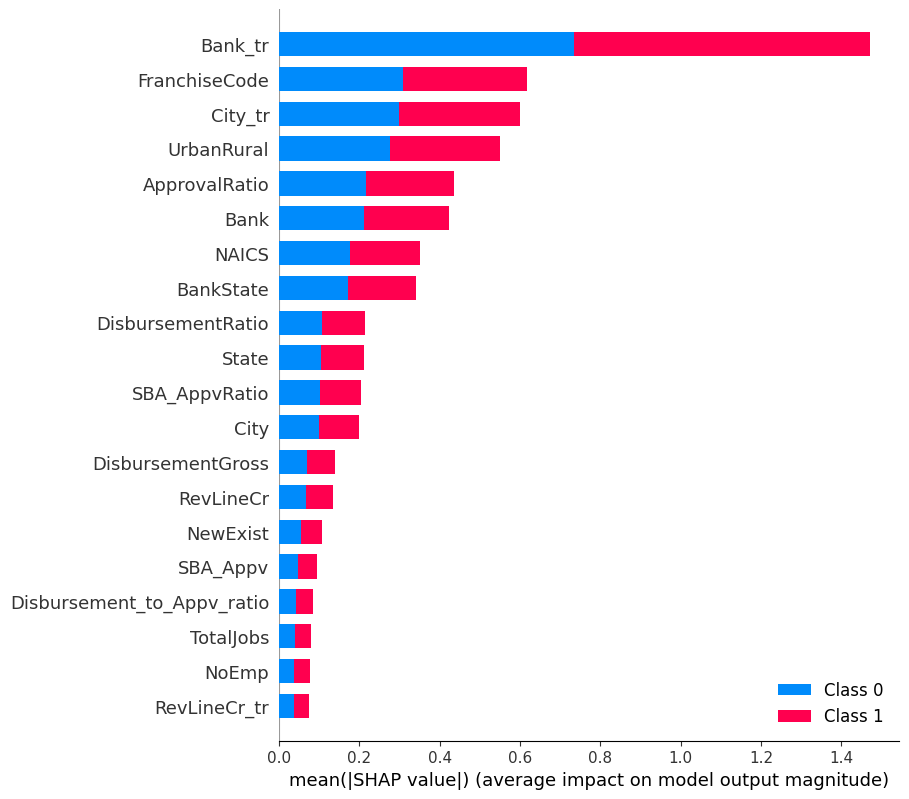

In [104]:
shap.summary_plot(shap_values, X_test, feature_names= X_test.columns, plot_type="bar")

The above graph shows SHAP values for each feature on the test set and create a summary plot showing the impact of each feature on the model's predictions on the test set.

Features are sorted by the sum of the SHAP value magnitudes across all samples. It is interesting to note that the **Bank_tr** feature has more total model impact than other variables

**Top features include - "Bank_tr, FranchiseCode, City_tr, and UrbanRural**

### Individual observations analysis using Shapley values. Two records for each of the scenarios with significant probability

In [130]:
shap.initjs()

In [175]:
#Calculating the X_predictions comparing to actual labels 

# Get the predicted probabilities for the validation set and Use the optimal threshold to predict the labels for the validation set
y_proba = best_lgb_model.predict_proba(X_test)
y_proba_test = best_lgb_model.predict_proba(X_test)[:, 1]
y_pred_test = (y_proba_test > optimal_threshold).astype(int)


actual_pred_df = pd.DataFrame({'actual': y_test, 'Predicitons': y_pred_test, 'Prob_0': y_proba[:,0], 'Prob_1': y_proba[:,1]})
actual_pred_df.reset_index(drop=True, inplace=True)


In [201]:
actual_pred_df.head(2)
# actual_pred_df[(actual_pred_df['Prob_0'] >0.97) & (actual_pred_df['actual'] == 1)].head(20)

,actual,Predicitons,Prob_0,Prob_1
0,1,1,0.390488,0.609512
1,0,0,0.999895,0.000105


### Incorrect Prediction record: 67 and 552; Actual = 1; classified as 0

In [192]:
# reset the index of the concatenated dataframe
X_test_shap.reset_index(drop=True, inplace=True)

# generate the force plot for the first instance in X_test_shap
shap.force_plot(explainer.expected_value[1], shap_values[1][67,:], X_test_shap.iloc[67,:])

In [199]:
shap.force_plot(explainer.expected_value[1], shap_values[1][552,:], X_test_shap.iloc[552,:])

#### Pasting image of graph below for reference in jupyter notebook

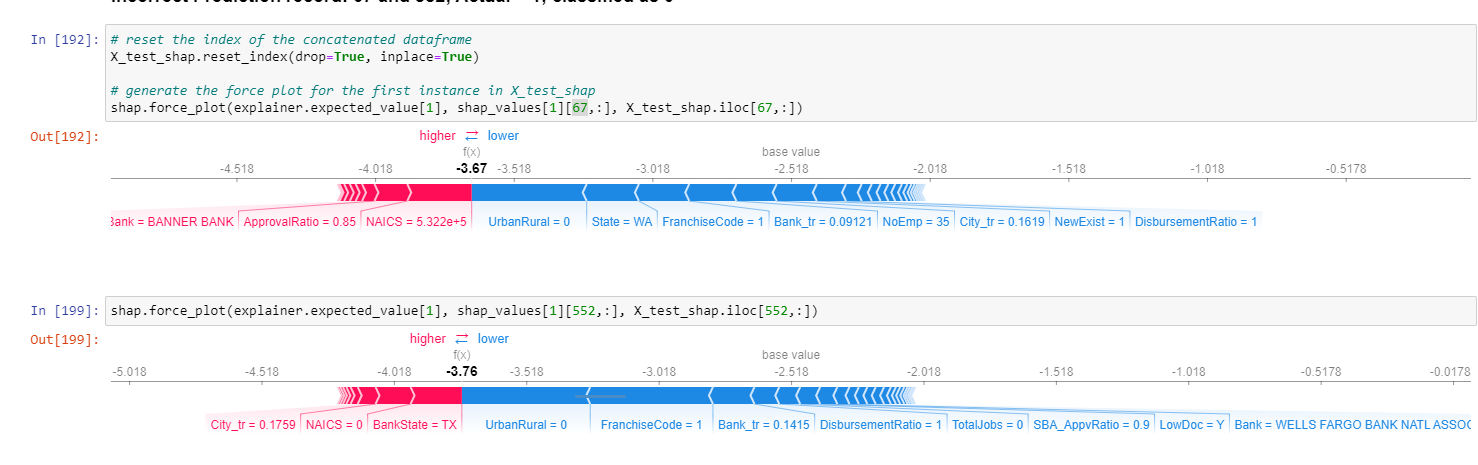

### Inference - record 67 and 552 :

1. Here the prediction is misclassified as a 'Default' when it was a 'Non-Default' case
2. The variables **UrbanRural, State, Bank_tr are the top columns that are pushing the probability** of 'MIS_Status' down and causing it to predict default.
3. **UrbanRural** is the major factor indicating that if someone is from rural area, model is thinking that this person will default. 

    Model seems to be making a judgement based on location for misclassified 'defaulted' cases.

##  -----------------------------------------------------------------------------------------------------------------------------------------------------------------------  ##

### Incorrect Prediction record: 1447 and 3508; Actual = 0; classified as 1

In [188]:
shap.force_plot(explainer.expected_value[1], shap_values[1][1447,:], X_test_shap.iloc[1447,:])

In [187]:
shap.force_plot(explainer.expected_value[1], shap_values[1][3508,:], X_test_shap.iloc[3508,:])

#### Pasting image of graph below for reference in jupyter notebook

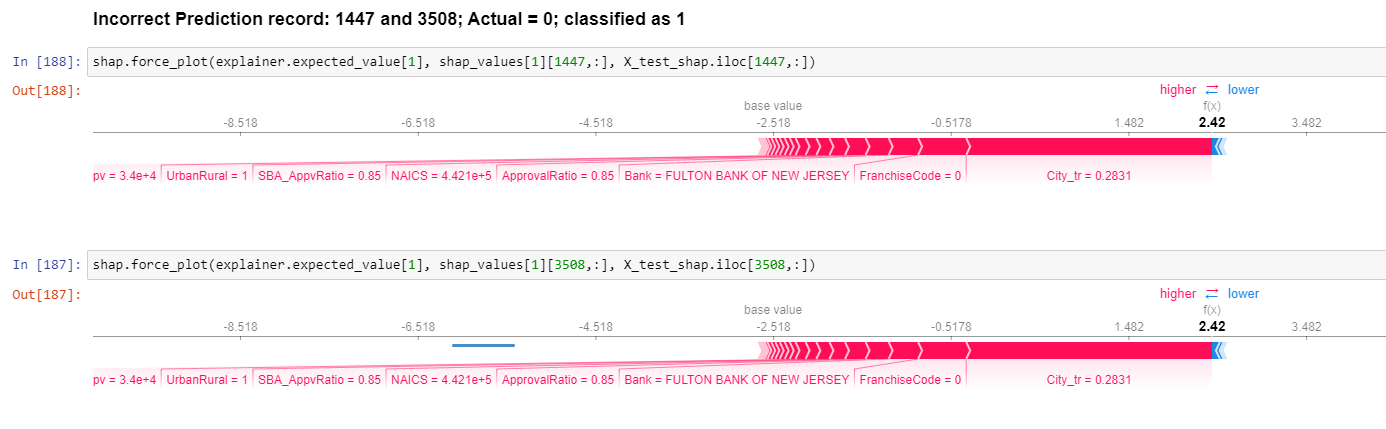

### Inference - record1447 and 3508: 

1. Here the prediction is misclassified as a 'Non-Default' when it was a 'Default' case
2. The variables **City, Bank, UrbanRural, are the top columns that are pushing the probability** of 'MIS_Status' up and causing it to predict Non-defaulter.
3. **City and UrbanRural** is the major factor indicating that if someone is from Urban area, model is thinking that this person will not default. 

   Again, it's safe to say that the model seems to be making a judgement based on location for misclassified 'defaulted' cases.

### In order to avoid that, we can probably come up with a rule based approach or a different model to better cater to location based judgement in the model 

##  -----------------------------------------------------------------------------------------------------------------------------------------------------------------------  ##

### Correctly Prediction record: 0 and 8; Actual = 1; classified as 1

In [184]:
# generate the force plot for the first instance in X_test_shap
shap.force_plot(explainer.expected_value[1], shap_values[1][49,:], X_test_shap.iloc[49,:])

In [185]:
shap.force_plot(explainer.expected_value[1], shap_values[1][62,:], X_test_shap.iloc[62,:])

#### Pasting image of graph below for reference in jupyter notebook

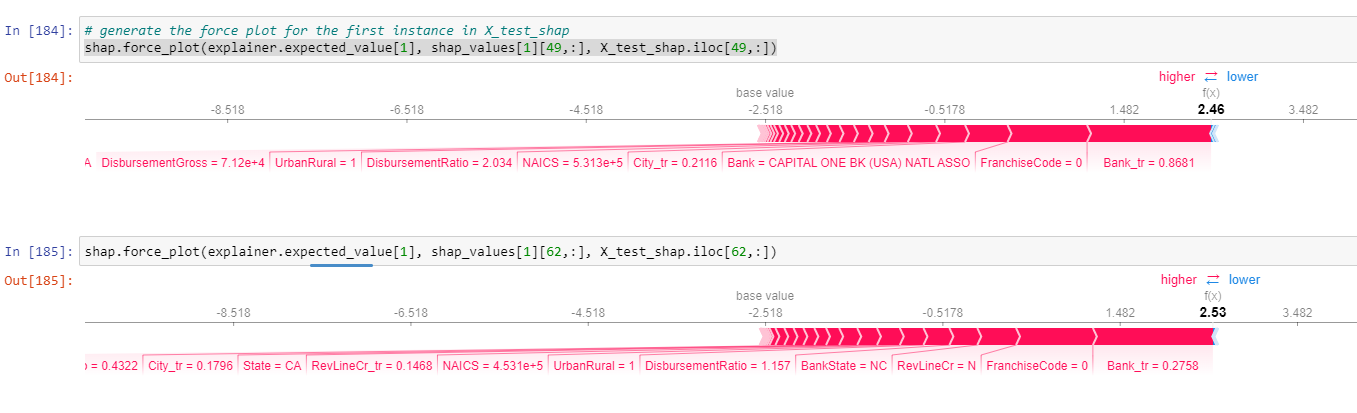

### Interence - record 0 and 8: 

1. Here the prediction is correctly classified/predicted as a 'Non-Default' by the model 
2. The variables **Bank, FranchiseCode, BankState, are the top columns that are pushing the probability** of 'MIS_Status' up and causing it to predict correctly
3. **Bank and FranchiseCode** is the major factor contributing to the prediction

### As we can also see from Global Feature importance, Bank_tr seems to be the best variable for predicting records

##  -----------------------------------------------------------------------------------------------------------------------------------------------------------------------  ##

### Correctly Prediction record: 1 and 3; Actual = 0; classified as 0

In [169]:
shap.force_plot(explainer.expected_value[1], shap_values[1][1,:], X_test_shap.iloc[1,:])

In [179]:
shap.force_plot(explainer.expected_value[1], shap_values[1][3,:], X_test_shap.iloc[3,:])

#### Pasting image of graph below for reference in jupyter notebook

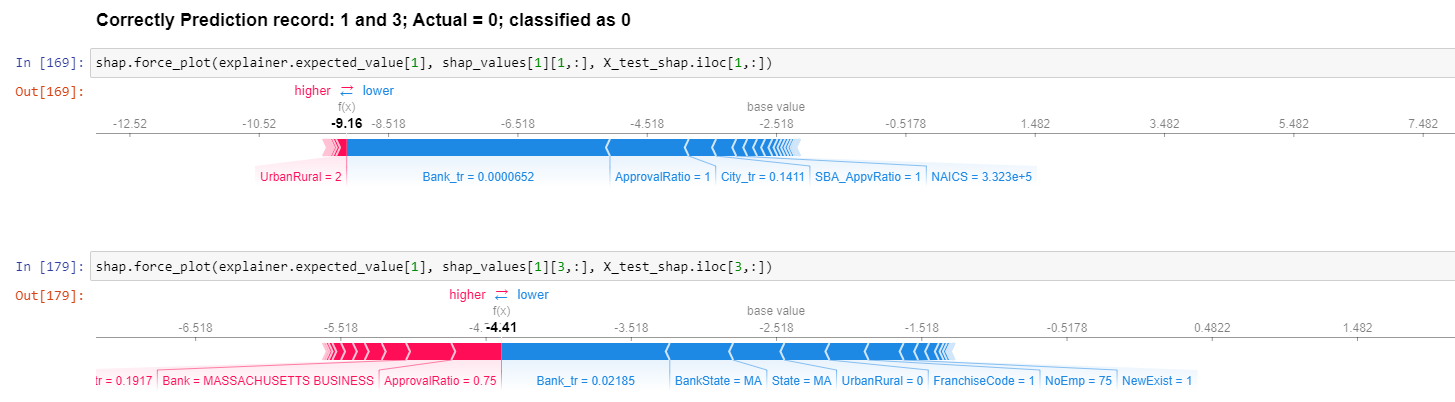

### Interence - record 1 and 3:

1. Here the prediction is correctly classified/predicted as a 'Non-Default' by the model 
2. The variables **Bank, ApprovalRatio, City, are the top columns that are pushing the probability** of 'MIS_Status' up and causing it to predict correctly
3. **Bank and ApprovalRatio** are the major factor contributing to prediction

### As we can also see from Global Feature importance, Bank_tr seems to be the best variable for predicting records

##  -----------------------------------------------------------------------------------------------------------------------------------------------------------------------  ##

##  -------------------------------------------------  PROJECT - FINAL THOUGHTS  ---------------------------------------------------  ##


This project started with the dataset **Should This Loan be Approved or Denied?"** - containing information about loan applicants and their credit histories, as well as information about whether or not their loan applications were approved

Th below steps were followed in this analysis:

#### 1. DATASET PREPARATION ####
- Loaded dataset
- Cleaned the dataset; removing any unnecessary values in all columns
- Missing values treatment was performed

#### 2. MODEL PREPARATION ####
- Dataset was split in Train, VAlidation and Test sets
- Encoding applied to train dataset; Validation and Test sets were transformed
- feature engineering applied to train dataset; Validation and Test sets were transformed
- Categorical variables handled for GBM models

#### 3. MODEL TRAINING, TUNING & RESULTS
- Trained LighGBM and GBM (H2O) models on train dataset; evaluation performed on validation set. Final performance evaludated on test dataset


- **LighGBM results**:


    - **Baseline model**: 
        - AUC score on Test dataset: 0.8264384046206024
        - AUC score on Train dataset: 0.8776365497223705
        
     - **Tuned model**: 
         - AUC score on Test dataset: 0.8333368174387217
         - AUC score on Val dataset: 0.8341439377226108
         - AUC score on Train dataset: 0.9025421850303198
         
     - **Final score after combining Train  & Val Data and testing on Test set:**
          - **AUC score: 0.8438100952869628**

    - **Other relevant scores:**
    
        - Best F1 score: 0.6107987418308642
        - AUC score: 0.8438100952869628

   -   **Confusion matrix:**
        
            [[117265  15932]
             [ 11455  16838]]

         - Optimum Threshold computed: 0.293

### ************Final AUC score for LighGBM: 84.381%****************




- **GBM (H2O) trained and tuned model results:**


    - Best Grid Model AUC on Test: 0.8364662159550983 
 
    - Best Grid Model AUC on Validation: 0.8370177292148119
    
*Now, Both LightGBM model and GBM (H2o) seems to have identical performance, Selected LighGBM model for scoring funtion and model explainability*
    
    
    
    
    

#### 4. CALCULATED BEST THRESHOLD BASED ON F1 SCORE FOR LIGHTGBM MODEL

- ***Optimal threshold = 0.293***



#### 5. SAVED ARTIFACTS IN FILE "ARTIFACTS_DICT_FILE"



#### 6. CREATED SCORING FUNCTION - "from scoring_func_project2 import project_2_scoring"

#### 7.  INTERPRET FINAL TRAINED MODEL USING TEST DATASET:

*During model interpretation, I found that the model seems to be making a judgement based on location for misclassified 'defaulted/non-default' cases.*

*In order to avoid that, we can probably come up with a rule based approach or a different model to better cater to location based judgement in the model*


## -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- ##
